# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [6]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsitya/' # adjust to match location of this Dryad repo folder
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherencea/' # adjust to match location of this Dryad repo folder
shuffload_folder3 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/peakheights/' # adjust to match location of this Dryad repo folder
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS2/' 

In [7]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [8]:
''' Find & save indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded''' 

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        
        #define indices for first two quarters accounting for skipped trials
        start_idx = (np.where(trial >= 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        enda_idx = (np.where(trial <= 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        endb_idx = (np.where(trial <= 139)[0][-1]).astype(int) # last index before alternation
        Aidx = np.arange(start_idx, enda_idx + 1, 1)
        Bidx = np.arange(enda_idx + 1, endb_idx + 1, 1)
        
        #find context A / B trials in alternation, removing skipped trials
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
               
        A_trials = np.where((left == 1))[0]
        A_trials = list(A_trials[A_trials >= 140])
        B_trials = np.where((left == 0))[0]
        B_trials = list(B_trials[B_trials >= 140])
    
        # Find skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []
            
        for n, t in enumerate(skippedtrials):
            if t in A_trials:
                A_trials.remove(t)
            elif t in B_trials:
                B_trials.remove(t)
    
        A_idx = []
        for t in A_trials:
            A_idx = np.append(A_idx, np.where(trial == t)[0])
            A_idx = A_idx.astype(int)
            
        B_idx = []
        for t in B_trials:
            B_idx = np.append(B_idx, np.where(trial == t)[0])
            B_idx = B_idx.astype(int)
            
        #save indices for session sections
        Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
        Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
        A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx
        
        np.save(save_folder + Aidx_file, Aidx)
        np.save(save_folder + Bidx_file, Bidx)
        np.save(save_folder + A_idx_file, A_idx)
        np.save(save_folder + B_idx_file, B_idx)
        #print('saved relevant data indices for future use') 
        
        # get non-gain change A' and B' indices 
        gain = trialinfo['gain']
        
        A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        #check if mouse reached gain period; if not append NaN to all arrays & continue 
        if len(gain) < 200:
            #print(str(m) + str(s) + ' did not reach gain change')
            
            d['A_ngidx'] = A_idx
            d['B_ngidx'] = B_idx
            
            np.save(save_folder + A_ngidx_file, A_idx)
            np.save(save_folder + B_ngidx_file, B_idx)
            
            continue 
            
        #get count of gain change trials in each context & select equal number of last Context A or B alt trials before gain
        gain_trials = np.where((gain == 0.7))[0]
        gain_trials = list(gain_trials)

        Agtrials = np.intersect1d(A_trials, np.asarray(gain_trials))
        Agtrials = list(np.sort(Agtrials.astype(int)))
        Bgtrials = np.intersect1d(B_trials, np.asarray(gain_trials))                   
        Bgtrials = list(np.sort(Bgtrials.astype(int)))
    
        #get indices of observations corresponding to the selected trials
        Agidx = []
        for t in Agtrials:
            Agidx = np.append(Agidx, np.where(trial == t)[0])
        Agidx = Agidx.astype(int)
            
        Bgidx = []
        for t in Bgtrials:
            Bgidx = np.append(Bgidx, np.where(trial == t)[0])
        Bgidx = Bgidx.astype(int)
        
        A_ngidx = np.setdiff1d(A_idx,Agidx).astype(int)
        B_ngidx = np.setdiff1d(B_idx,Bgidx).astype(int)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx
        
        np.save(save_folder + A_ngidx_file, A_ngidx)
        np.save(save_folder + B_ngidx_file, B_ngidx)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Classify Spatial Cells using Shuffle Scores or Skip to next Section

You'll only need to run this section only once in order to generate spatial cell booleans for these sessions.

In [16]:
''' Calculate & Save Spatial Coherence & Sparsity Scores for all Sessions '''

dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session, leave=False):
        d = data[m][s]
        
        #get data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        total_time = max(post) - min(post)
        
        #delineate contexta 
        start_idx = (np.where(trial == 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        end_idx = (np.where(trial == 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        A = Y[start_idx:end_idx, :]
        aposxfil = posx[start_idx:end_idx]
        
        #get smoothed FR & sparsity scores 
        asmoothFR, _, asmoothocc = ps.tuning_curve(aposxfil, A, dt, b = 2, l=2, smooth=True, SEM=False, occupancy=True)
        aFR, _ , _ = ps.tuning_curve(aposxfil, A, dt, b = 2, l=2, smooth=False, SEM=False, occupancy=True)      
        
        #calculate sparsity with smoothed FR in Context A
        sparsitya_scores = []
        totala_time = max(post[start_idx:end_idx]) - min(post[start_idx:end_idx])
        for i, c in enumerate(cell_IDs):
            meanFRsqr = np.square(np.mean(asmoothFR[:,i]))
            products = []
            for b in range(asmoothFR.shape[0]):
                binmeanFRsqr = np.square(asmoothFR[b,i])
                prob = asmoothocc[b,i]/totala_time
                prod = prob * binmeanFRsqr
                products = np.append(products,prod)
            asparsity = np.sum(products) / meanFRsqr
            sparsitya_scores = np.append(sparsitya_scores,asparsity)
        d['spatialasparsity'] = sparsitya_scores

        # calculate spatial tuning coherence score with non-smoothed FR in Context A
        spatialacoherence_scores = []
        for i, c in enumerate(cell_IDs):
            neighbors = get.find8adjacentElements(aFR[:,i])
            meanFR_neighbors = []
            for b in range(aFR.shape[0]):
                meanFR_neigh = np.mean(neighbors[b])
                meanFR_neighbors = np.append(meanFR_neighbors, meanFR_neigh)
            acoherence, _ = stats.pearsonr(aFR[:,i],meanFR_neighbors)
            if math.isnan(acoherence):
                spatialacoherence_scores = np.append(spatialacoherence_scores,0)
            else:
                spatialacoherence_scores = np.append(spatialacoherence_scores,acoherence)
        d['spatialacoherencescores'] = spatialacoherence_scores
    
        #Get file names & save scores as npy files
        sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
        spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy'    
        
        np.save(save_folder + sparsityascore_file, sparsitya_scores)
        #print('saved sparsity A scores as npy file for mouse ' + m + ' session '+ s)

        np.save(save_folder + spatialacoherencescore_file, spatialacoherence_scores)
        #print('saved spatial coherence A scores as npy file for mouse ' + m + ' session '+ s)

  0%|          | 0/3 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A14 session 083022_record1
saved spatial coherence A scores as npy file for mouse A14 session 083022_record1
saved sparsity A scores as npy file for mouse A14 session 083122_record2
saved spatial coherence A scores as npy file for mouse A14 session 083122_record2
saved sparsity A scores as npy file for mouse A14 session 090122_record3
saved spatial coherence A scores as npy file for mouse A14 session 090122_record3


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A15 session 083022_record1
saved spatial coherence A scores as npy file for mouse A15 session 083022_record1


C:\Users\Python\AppData\Local\Temp\ipykernel_22348\212483658.py:44: RuntimeWarning: invalid value encountered in scalar divide
  asparsity = np.sum(products) / meanFRsqr
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


saved sparsity A scores as npy file for mouse A15 session 083122_record2
saved spatial coherence A scores as npy file for mouse A15 session 083122_record2
saved sparsity A scores as npy file for mouse A15 session 090122_record3
saved spatial coherence A scores as npy file for mouse A15 session 090122_record3
saved sparsity A scores as npy file for mouse A15 session 090222_record4
saved spatial coherence A scores as npy file for mouse A15 session 090222_record4
saved sparsity A scores as npy file for mouse A15 session 090322_record5
saved spatial coherence A scores as npy file for mouse A15 session 090322_record5
saved sparsity A scores as npy file for mouse A15 session 090422_record6
saved spatial coherence A scores as npy file for mouse A15 session 090422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A16 session 083022_record1
saved spatial coherence A scores as npy file for mouse A16 session 083022_record1
saved sparsity A scores as npy file for mouse A16 session 083122_record2
saved spatial coherence A scores as npy file for mouse A16 session 083122_record2
saved sparsity A scores as npy file for mouse A16 session 090122_record3
saved spatial coherence A scores as npy file for mouse A16 session 090122_record3
saved sparsity A scores as npy file for mouse A16 session 090222_record4
saved spatial coherence A scores as npy file for mouse A16 session 090222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A17 session 082322_record1
saved spatial coherence A scores as npy file for mouse A17 session 082322_record1
saved sparsity A scores as npy file for mouse A17 session 082422_record2
saved spatial coherence A scores as npy file for mouse A17 session 082422_record2
saved sparsity A scores as npy file for mouse A17 session 082522_record3
saved spatial coherence A scores as npy file for mouse A17 session 082522_record3
saved sparsity A scores as npy file for mouse A17 session 082622_record4
saved spatial coherence A scores as npy file for mouse A17 session 082622_record4
saved sparsity A scores as npy file for mouse A17 session 082722_record5
saved spatial coherence A scores as npy file for mouse A17 session 082722_record5
saved sparsity A scores as npy file for mouse A17 session 082822_record6
saved spatial coherence A scores as npy file for mouse A17 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A18 session 082322_record1real
saved spatial coherence A scores as npy file for mouse A18 session 082322_record1real
saved sparsity A scores as npy file for mouse A18 session 082422_record2
saved spatial coherence A scores as npy file for mouse A18 session 082422_record2
saved sparsity A scores as npy file for mouse A18 session 082522_record3
saved spatial coherence A scores as npy file for mouse A18 session 082522_record3
saved sparsity A scores as npy file for mouse A18 session 082622_record4
saved spatial coherence A scores as npy file for mouse A18 session 082622_record4
saved sparsity A scores as npy file for mouse A18 session 082722_record5
saved spatial coherence A scores as npy file for mouse A18 session 082722_record5
saved sparsity A scores as npy file for mouse A18 session 082822_record6
saved spatial coherence A scores as npy file for mouse A18 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A19 session 012723_record2
saved spatial coherence A scores as npy file for mouse A19 session 012723_record2
saved sparsity A scores as npy file for mouse A19 session 012823_record3
saved spatial coherence A scores as npy file for mouse A19 session 012823_record3
saved sparsity A scores as npy file for mouse A19 session 012923_record4
saved spatial coherence A scores as npy file for mouse A19 session 012923_record4
saved sparsity A scores as npy file for mouse A19 session 013023_record5
saved spatial coherence A scores as npy file for mouse A19 session 013023_record5
saved sparsity A scores as npy file for mouse A19 session 013123_record6
saved spatial coherence A scores as npy file for mouse A19 session 013123_record6
saved sparsity A scores as npy file for mouse A19 session 020123_record7
saved spatial coherence A scores as npy file for mouse A19 session 020123_record7


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A20 session 012623_record1
saved spatial coherence A scores as npy file for mouse A20 session 012623_record1
saved sparsity A scores as npy file for mouse A20 session 012723_record2
saved spatial coherence A scores as npy file for mouse A20 session 012723_record2
saved sparsity A scores as npy file for mouse A20 session 012823_record3
saved spatial coherence A scores as npy file for mouse A20 session 012823_record3
saved sparsity A scores as npy file for mouse A20 session 012923_record4
saved spatial coherence A scores as npy file for mouse A20 session 012923_record4
saved sparsity A scores as npy file for mouse A20 session 013023_record5
saved spatial coherence A scores as npy file for mouse A20 session 013023_record5
saved sparsity A scores as npy file for mouse A20 session 013123_record6
saved spatial coherence A scores as npy file for mouse A20 session 013123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A22 session 012923_record2
saved spatial coherence A scores as npy file for mouse A22 session 012923_record2
saved sparsity A scores as npy file for mouse A22 session 013023_record3
saved spatial coherence A scores as npy file for mouse A22 session 013023_record3
saved sparsity A scores as npy file for mouse A22 session 013123_record4
saved spatial coherence A scores as npy file for mouse A22 session 013123_record4
saved sparsity A scores as npy file for mouse A22 session 020123_record5
saved spatial coherence A scores as npy file for mouse A22 session 020123_record5
saved sparsity A scores as npy file for mouse A22 session 020223_record6
saved spatial coherence A scores as npy file for mouse A22 session 020223_record6
saved sparsity A scores as npy file for mouse A22 session 020323_record7
saved spatial coherence A scores as npy file for mouse A22 session 020323_record7


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A23 session 020923_record1
saved spatial coherence A scores as npy file for mouse A23 session 020923_record1
saved sparsity A scores as npy file for mouse A23 session 021023_record2
saved spatial coherence A scores as npy file for mouse A23 session 021023_record2
saved sparsity A scores as npy file for mouse A23 session 021123_record3
saved spatial coherence A scores as npy file for mouse A23 session 021123_record3
saved sparsity A scores as npy file for mouse A23 session 021223_record4
saved spatial coherence A scores as npy file for mouse A23 session 021223_record4
saved sparsity A scores as npy file for mouse A23 session 021323_record5
saved spatial coherence A scores as npy file for mouse A23 session 021323_record5
saved sparsity A scores as npy file for mouse A23 session 021423_record6
saved spatial coherence A scores as npy file for mouse A23 session 021423_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A24 session 022623_record1
saved spatial coherence A scores as npy file for mouse A24 session 022623_record1
saved sparsity A scores as npy file for mouse A24 session 022723_record2
saved spatial coherence A scores as npy file for mouse A24 session 022723_record2
saved sparsity A scores as npy file for mouse A24 session 022823_record3
saved spatial coherence A scores as npy file for mouse A24 session 022823_record3
saved sparsity A scores as npy file for mouse A24 session 030123_record4
saved spatial coherence A scores as npy file for mouse A24 session 030123_record4
saved sparsity A scores as npy file for mouse A24 session 030223_record5
saved spatial coherence A scores as npy file for mouse A24 session 030223_record5
saved sparsity A scores as npy file for mouse A24 session 030323_record6
saved spatial coherence A scores as npy file for mouse A24 session 030323_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA10F session 111322_record1
saved spatial coherence A scores as npy file for mouse MA10F session 111322_record1
saved sparsity A scores as npy file for mouse MA10F session 111422_record2
saved spatial coherence A scores as npy file for mouse MA10F session 111422_record2
saved sparsity A scores as npy file for mouse MA10F session 111522_record3
saved spatial coherence A scores as npy file for mouse MA10F session 111522_record3
saved sparsity A scores as npy file for mouse MA10F session 111622_record4
saved spatial coherence A scores as npy file for mouse MA10F session 111622_record4
saved sparsity A scores as npy file for mouse MA10F session 111722_record5
saved spatial coherence A scores as npy file for mouse MA10F session 111722_record5
saved sparsity A scores as npy file for mouse MA10F session 111822_record6
saved spatial coherence A scores as npy file for mouse MA10F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA1F session 102322_record1
saved spatial coherence A scores as npy file for mouse MA1F session 102322_record1
saved sparsity A scores as npy file for mouse MA1F session 102422_record2
saved spatial coherence A scores as npy file for mouse MA1F session 102422_record2
saved sparsity A scores as npy file for mouse MA1F session 102522_record3
saved spatial coherence A scores as npy file for mouse MA1F session 102522_record3
saved sparsity A scores as npy file for mouse MA1F session 102622_record4
saved spatial coherence A scores as npy file for mouse MA1F session 102622_record4
saved sparsity A scores as npy file for mouse MA1F session 102722_record5
saved spatial coherence A scores as npy file for mouse MA1F session 102722_record5
saved sparsity A scores as npy file for mouse MA1F session 102822_record6
saved spatial coherence A scores as npy file for mouse MA1F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA2F session 102322_record1
saved spatial coherence A scores as npy file for mouse MA2F session 102322_record1
saved sparsity A scores as npy file for mouse MA2F session 102422_record2
saved spatial coherence A scores as npy file for mouse MA2F session 102422_record2
saved sparsity A scores as npy file for mouse MA2F session 102522_record3
saved spatial coherence A scores as npy file for mouse MA2F session 102522_record3
saved sparsity A scores as npy file for mouse MA2F session 102622_record4
saved spatial coherence A scores as npy file for mouse MA2F session 102622_record4
saved sparsity A scores as npy file for mouse MA2F session 102722_record5
saved spatial coherence A scores as npy file for mouse MA2F session 102722_record5
saved sparsity A scores as npy file for mouse MA2F session 102822_record6
saved spatial coherence A scores as npy file for mouse MA2F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA3M session 102322_record1
saved spatial coherence A scores as npy file for mouse MA3M session 102322_record1
saved sparsity A scores as npy file for mouse MA3M session 102422_record2
saved spatial coherence A scores as npy file for mouse MA3M session 102422_record2
saved sparsity A scores as npy file for mouse MA3M session 102522_record3
saved spatial coherence A scores as npy file for mouse MA3M session 102522_record3
saved sparsity A scores as npy file for mouse MA3M session 102622_record4
saved spatial coherence A scores as npy file for mouse MA3M session 102622_record4
saved sparsity A scores as npy file for mouse MA3M session 102722_record5
saved spatial coherence A scores as npy file for mouse MA3M session 102722_record5
saved sparsity A scores as npy file for mouse MA3M session 102822_record6
saved spatial coherence A scores as npy file for mouse MA3M session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA4M session 103122_record2
saved spatial coherence A scores as npy file for mouse MA4M session 103122_record2
saved sparsity A scores as npy file for mouse MA4M session 110122_record3
saved spatial coherence A scores as npy file for mouse MA4M session 110122_record3
saved sparsity A scores as npy file for mouse MA4M session 110222_record4
saved spatial coherence A scores as npy file for mouse MA4M session 110222_record4
saved sparsity A scores as npy file for mouse MA4M session 110322_record5rep
saved spatial coherence A scores as npy file for mouse MA4M session 110322_record5rep
saved sparsity A scores as npy file for mouse MA4M session 110422_record6
saved spatial coherence A scores as npy file for mouse MA4M session 110422_record6
saved sparsity A scores as npy file for mouse MA4M session 110522_record7
saved spatial coherence A scores as npy file for mouse MA4M session 110522_record7


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA5M session 110622_record1
saved spatial coherence A scores as npy file for mouse MA5M session 110622_record1
saved sparsity A scores as npy file for mouse MA5M session 110722_record2
saved spatial coherence A scores as npy file for mouse MA5M session 110722_record2
saved sparsity A scores as npy file for mouse MA5M session 110822_record3
saved spatial coherence A scores as npy file for mouse MA5M session 110822_record3
saved sparsity A scores as npy file for mouse MA5M session 110922_record4
saved spatial coherence A scores as npy file for mouse MA5M session 110922_record4
saved sparsity A scores as npy file for mouse MA5M session 111022_record5
saved spatial coherence A scores as npy file for mouse MA5M session 111022_record5
saved sparsity A scores as npy file for mouse MA5M session 111122_record6
saved spatial coherence A scores as npy file for mouse MA5M session 111122_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA6M session 103022_record1
saved spatial coherence A scores as npy file for mouse MA6M session 103022_record1
saved sparsity A scores as npy file for mouse MA6M session 103122_record2
saved spatial coherence A scores as npy file for mouse MA6M session 103122_record2
saved sparsity A scores as npy file for mouse MA6M session 110122_record3
saved spatial coherence A scores as npy file for mouse MA6M session 110122_record3
saved sparsity A scores as npy file for mouse MA6M session 110222_record4
saved spatial coherence A scores as npy file for mouse MA6M session 110222_record4
saved sparsity A scores as npy file for mouse MA6M session 110322_record5
saved spatial coherence A scores as npy file for mouse MA6M session 110322_record5
saved sparsity A scores as npy file for mouse MA6M session 110422_record6
saved spatial coherence A scores as npy file for mouse MA6M session 110422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA7M session 103022_record1
saved spatial coherence A scores as npy file for mouse MA7M session 103022_record1
saved sparsity A scores as npy file for mouse MA7M session 103122_record2
saved spatial coherence A scores as npy file for mouse MA7M session 103122_record2
saved sparsity A scores as npy file for mouse MA7M session 110122_record3
saved spatial coherence A scores as npy file for mouse MA7M session 110122_record3
saved sparsity A scores as npy file for mouse MA7M session 110222_record4
saved spatial coherence A scores as npy file for mouse MA7M session 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA8F session 111322_record1
saved spatial coherence A scores as npy file for mouse MA8F session 111322_record1
saved sparsity A scores as npy file for mouse MA8F session 111422_record2
saved spatial coherence A scores as npy file for mouse MA8F session 111422_record2
saved sparsity A scores as npy file for mouse MA8F session 111522_record3
saved spatial coherence A scores as npy file for mouse MA8F session 111522_record3
saved sparsity A scores as npy file for mouse MA8F session 111622_record4
saved spatial coherence A scores as npy file for mouse MA8F session 111622_record4
saved sparsity A scores as npy file for mouse MA8F session 111722_record5
saved spatial coherence A scores as npy file for mouse MA8F session 111722_record5
saved sparsity A scores as npy file for mouse MA8F session 111822_record6
saved spatial coherence A scores as npy file for mouse MA8F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA9F session 111322_record1
saved spatial coherence A scores as npy file for mouse MA9F session 111322_record1
saved sparsity A scores as npy file for mouse MA9F session 111422_record2
saved spatial coherence A scores as npy file for mouse MA9F session 111422_record2
saved sparsity A scores as npy file for mouse MA9F session 111522_record3
saved spatial coherence A scores as npy file for mouse MA9F session 111522_record3
saved sparsity A scores as npy file for mouse MA9F session 111622_record4
saved spatial coherence A scores as npy file for mouse MA9F session 111622_record4
saved sparsity A scores as npy file for mouse MA9F session 111722_record5
saved spatial coherence A scores as npy file for mouse MA9F session 111722_record5
saved sparsity A scores as npy file for mouse MA9F session 111822_record6
saved spatial coherence A scores as npy file for mouse MA9F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y20 session 092522_record1
saved spatial coherence A scores as npy file for mouse Y20 session 092522_record1
saved sparsity A scores as npy file for mouse Y20 session 092622_record2
saved spatial coherence A scores as npy file for mouse Y20 session 092622_record2
saved sparsity A scores as npy file for mouse Y20 session 092722_record3
saved spatial coherence A scores as npy file for mouse Y20 session 092722_record3
saved sparsity A scores as npy file for mouse Y20 session 092822_record4
saved spatial coherence A scores as npy file for mouse Y20 session 092822_record4
saved sparsity A scores as npy file for mouse Y20 session 092922_record5
saved spatial coherence A scores as npy file for mouse Y20 session 092922_record5
saved sparsity A scores as npy file for mouse Y20 session 093022_record6
saved spatial coherence A scores as npy file for mouse Y20 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y21 session 091822_record1
saved spatial coherence A scores as npy file for mouse Y21 session 091822_record1
saved sparsity A scores as npy file for mouse Y21 session 091922_record2
saved spatial coherence A scores as npy file for mouse Y21 session 091922_record2
saved sparsity A scores as npy file for mouse Y21 session 092022_record3
saved spatial coherence A scores as npy file for mouse Y21 session 092022_record3
saved sparsity A scores as npy file for mouse Y21 session 092122_record4
saved spatial coherence A scores as npy file for mouse Y21 session 092122_record4
saved sparsity A scores as npy file for mouse Y21 session 092222_record5
saved spatial coherence A scores as npy file for mouse Y21 session 092222_record5
saved sparsity A scores as npy file for mouse Y21 session 092322_record6
saved spatial coherence A scores as npy file for mouse Y21 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y22 session 092522_record1
saved spatial coherence A scores as npy file for mouse Y22 session 092522_record1
saved sparsity A scores as npy file for mouse Y22 session 092622_record2
saved spatial coherence A scores as npy file for mouse Y22 session 092622_record2
saved sparsity A scores as npy file for mouse Y22 session 092722_record3
saved spatial coherence A scores as npy file for mouse Y22 session 092722_record3
saved sparsity A scores as npy file for mouse Y22 session 092822_record4
saved spatial coherence A scores as npy file for mouse Y22 session 092822_record4
saved sparsity A scores as npy file for mouse Y22 session 092922_record5
saved spatial coherence A scores as npy file for mouse Y22 session 092922_record5
saved sparsity A scores as npy file for mouse Y22 session 093022_record6
saved spatial coherence A scores as npy file for mouse Y22 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y23 session 092522_record1
saved spatial coherence A scores as npy file for mouse Y23 session 092522_record1
saved sparsity A scores as npy file for mouse Y23 session 092622_record2
saved spatial coherence A scores as npy file for mouse Y23 session 092622_record2
saved sparsity A scores as npy file for mouse Y23 session 092722_record3
saved spatial coherence A scores as npy file for mouse Y23 session 092722_record3
saved sparsity A scores as npy file for mouse Y23 session 092822_record4
saved spatial coherence A scores as npy file for mouse Y23 session 092822_record4
saved sparsity A scores as npy file for mouse Y23 session 092922_record5
saved spatial coherence A scores as npy file for mouse Y23 session 092922_record5
saved sparsity A scores as npy file for mouse Y23 session 093022_record6
saved spatial coherence A scores as npy file for mouse Y23 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y24 session 091822_record1
saved spatial coherence A scores as npy file for mouse Y24 session 091822_record1
saved sparsity A scores as npy file for mouse Y24 session 091922_record2
saved spatial coherence A scores as npy file for mouse Y24 session 091922_record2
saved sparsity A scores as npy file for mouse Y24 session 092022_record3
saved spatial coherence A scores as npy file for mouse Y24 session 092022_record3
saved sparsity A scores as npy file for mouse Y24 session 092122_record4
saved spatial coherence A scores as npy file for mouse Y24 session 092122_record4
saved sparsity A scores as npy file for mouse Y24 session 092222_record5
saved spatial coherence A scores as npy file for mouse Y24 session 092222_record5
saved sparsity A scores as npy file for mouse Y24 session 092322_record6
saved spatial coherence A scores as npy file for mouse Y24 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y25 session 021623_record1
saved spatial coherence A scores as npy file for mouse Y25 session 021623_record1
saved sparsity A scores as npy file for mouse Y25 session 021723_record2
saved spatial coherence A scores as npy file for mouse Y25 session 021723_record2
saved sparsity A scores as npy file for mouse Y25 session 021823_record3
saved spatial coherence A scores as npy file for mouse Y25 session 021823_record3
saved sparsity A scores as npy file for mouse Y25 session 021923_record4
saved spatial coherence A scores as npy file for mouse Y25 session 021923_record4
saved sparsity A scores as npy file for mouse Y25 session 022023_record5
saved spatial coherence A scores as npy file for mouse Y25 session 022023_record5
saved sparsity A scores as npy file for mouse Y25 session 022123_record6
saved spatial coherence A scores as npy file for mouse Y25 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y26 session 021623_record1
saved spatial coherence A scores as npy file for mouse Y26 session 021623_record1
saved sparsity A scores as npy file for mouse Y26 session 021723_record2
saved spatial coherence A scores as npy file for mouse Y26 session 021723_record2
saved sparsity A scores as npy file for mouse Y26 session 021823_record3
saved spatial coherence A scores as npy file for mouse Y26 session 021823_record3
saved sparsity A scores as npy file for mouse Y26 session 021923_record4
saved spatial coherence A scores as npy file for mouse Y26 session 021923_record4
saved sparsity A scores as npy file for mouse Y26 session 022023_record5
saved spatial coherence A scores as npy file for mouse Y26 session 022023_record5
saved sparsity A scores as npy file for mouse Y26 session 022123_record6
saved spatial coherence A scores as npy file for mouse Y26 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y27 session 021623_record1
saved spatial coherence A scores as npy file for mouse Y27 session 021623_record1
saved sparsity A scores as npy file for mouse Y27 session 021723_record2
saved spatial coherence A scores as npy file for mouse Y27 session 021723_record2
saved sparsity A scores as npy file for mouse Y27 session 021823_record3
saved spatial coherence A scores as npy file for mouse Y27 session 021823_record3
saved sparsity A scores as npy file for mouse Y27 session 021923_record4
saved spatial coherence A scores as npy file for mouse Y27 session 021923_record4
saved sparsity A scores as npy file for mouse Y27 session 022023_record5rep
saved spatial coherence A scores as npy file for mouse Y27 session 022023_record5rep
saved sparsity A scores as npy file for mouse Y27 session 022123_record6
saved spatial coherence A scores as npy file for mouse Y27 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y28 session 022623_record1
saved spatial coherence A scores as npy file for mouse Y28 session 022623_record1
saved sparsity A scores as npy file for mouse Y28 session 022723_record2
saved spatial coherence A scores as npy file for mouse Y28 session 022723_record2
saved sparsity A scores as npy file for mouse Y28 session 022823_record3
saved spatial coherence A scores as npy file for mouse Y28 session 022823_record3
saved sparsity A scores as npy file for mouse Y28 session 030123_record4
saved spatial coherence A scores as npy file for mouse Y28 session 030123_record4
saved sparsity A scores as npy file for mouse Y28 session 030223_record5
saved spatial coherence A scores as npy file for mouse Y28 session 030223_record5
saved sparsity A scores as npy file for mouse Y28 session 030323_record6
saved spatial coherence A scores as npy file for mouse Y28 session 030323_record6


In [ ]:
''' Load Saved Shuffle Scores to Classify Spatial Cells

Note : intn boolen & shuffled scores are produced by the notebook "Shuffle Procedure...." Please run that for all sessions before 
proceeding here or use saved scores in Dryad repository


'''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        shufsparsityascore_file = 'shufsparsityascores_' + m + '_' + s + '.npy'
        shufspatialacoherencescore_file = 'shufspatialacoherencescores_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load npy files       

        d['shuffsparsityascores'] = np.load(shuffload_folder1 + shufsparsityascore_file, allow_pickle=False)
        d['shuffspatialacoherencescores'] = np.load(shuffload_folder2 + shufspatialacoherencescore_file, allow_pickle=False)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        d['intn'] = d['intn'].astype(bool)

        
        try:
            _ = d['spatialasparsity'].shape
        except:
            print('loading previously generated sparsity & coherence scores...')
            sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
            spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy' 
            
            d['spatialasparsity'] = np.load(save_folder + sparsityascore_file, allow_pickle=True)
            d['spatialacoherencescores'] = np.load(save_folder + spatialacoherencescore_file, allow_pickle=True)

In [11]:
''' Gather total number of SM cells'''

young_count = 0
MA_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in SM_aged_mice:
            age_count += len(cell_IDs)
        elif m in SM_MA_mice:
            MA_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, MA_count, age_count)

15152 15011 13225


In [ ]:
''' Classify Spatial Cells from Context A Sparsity & Coherence or skip to the next cell if you've done this before '''

per99c = []
per99s = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 
        intn = d['intn']
        
        #Classify spatial cells as those > P99 of both Context A shuffle sparsity & coherence score distributions
        spatialcell99 = []
        for i, c in enumerate(cell_IDs):

            dist1 = shuffspatialacoherencescores[:,i]
            P991 = np.nanpercentile(dist1,99)

            dist2 = shuffsparsityascores[:,i]
            P992 = np.nanpercentile(dist2,99)
            
            per99c.append(P991)
            per99s.append(P992)

            if intn[i] == True: #spatial cells must be excitatory
                spatialcell99 = np.append(spatialcell99, False)
            elif (spatialacoherence_scores[i] > P991) & (sparsitya_scores[i] > P992):
                spatialcell99 = np.append(spatialcell99, True)
            else:
                spatialcell99 = np.append(spatialcell99, False)
        spatialcell99 = np.asarray(spatialcell99).astype(bool)

        #save speed cell IDs in nested list for all animals
        d['spatialcell99'] = spatialcell99    
        #print('% spatial cells = ' + str(100*len(cell_IDs[spatialcell99])/len(cell_IDs)))
        
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        np.save(save_folder + spatialcell99_file, spatialcell99)
        #print('saved spatial cell booleans as npy files for mouse ' + m + ' session '+ s)

print('\nMean ± SEM Coherence P99: ' + str(np.nanmean(per99c)) + ' ± ' + str(stats.sem(per99c, nan_policy = 'omit')))
print('Mean ± SEM Sparsity P99: ' + str(np.nanmean(per99s)) + ' ± ' + str(stats.sem(per99s,  nan_policy = 'omit'))) 

# If you've run the cells above before, run the one below to load spatial cells.

In [12]:
''' Alternatively, load existing spatial cell and intn booleans. '''

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load stuff
        d['spatialcell99'] = np.load(save_folder + spatialcell99_file, allow_pickle = True)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Filter Split Maze Spatial Cells to Remove Lickport Artifact Cells

In [13]:
''' Apply FR threshold for noisiness to spatial cells (Run time < 1 min / session (167 sessions)) '''

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        Aidx = d['Aidx']
        Bidx = d['Bidx']
        
        #load in spatial cells & interneurons classified elsewhere
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        intn = d['intn']
                
        #define indices excluding reward zone starts
        reward = raw.item().get('reward')
        centers = reward['centers']
        centera = centers[0]
        if centera == 270:
            centerb = 370
        else:
            centerb = 270
        
        # generate aligned position tuning curve
        aFR, abinned_pos, aFR_sem, occ = ps.tuning_curve(posxfil[Aidx], Y[Aidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        bFR, bbinned_pos, bFR_sem, occ = ps.tuning_curve(posxfil[Bidx], Y[Bidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        
        #find indices of bins not including 50cm pre-post reward centers (220 to 255 and 320 to 355)
        aidx = np.where((abinned_pos > (centera - 50)) & (abinned_pos <= (centera - 15)))
        maska = np.ones(len(abinned_pos), bool)
        maska[aidx] = 0
        bidx = np.where((bbinned_pos > (centerb - 50)) & (bbinned_pos <= (centerb - 15)))
        maskb = np.ones(len(bbinned_pos), bool)
        maskb[bidx] = 0
        
        noisycells = []
        for i, c in enumerate(cell_IDs):
            if (np.mean(aFR_sem[maska,i]) > np.mean(aFR[maska,i])*.45) and (np.mean(bFR_sem[maskb,i]) > np.mean(bFR[maskb,i])*.45):
                noisycells = np.append(noisycells, c)
                
        # filter out noisy cells from both grid and ngs cells and low firing grid cells    
        for i, c in enumerate(cell_IDs):           
            if (c in noisycells):
                spatialcell99[i] = 0
                spatialcell99[i] = 0
                
        #Save booleans
        spatialcell99 = spatialcell99.astype(bool)
        d['spatialcell99'] = spatialcell99

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Assess density of spatial cells.

In [14]:
''' Load saved spatial cell booleans & glance at overall density '''

perspatial = []
sperspatial = []
mperspatial = []

for m, session in zip(mice,sessions):
    
    m_perspatial = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        spatialcell = d['spatialcell99'].astype(bool)
        
        print(m + ', ' + s + ' n spatial cells: '+ str(np.sum(spatialcell)))
        perspatial = np.append(perspatial, 100*np.sum(spatialcell)/len(cell_IDs))        
        sperspatial = np.append(sperspatial, 100*np.sum(spatialcell)/len(cell_IDs))
        m_perspatial = np.append(m_perspatial, np.sum(spatialcell))
        m_cells = np.append(m_cells, len(cell_IDs))
    
    mperspatial = np.append(mperspatial, np.sum(m_perspatial)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n spatial cells: 67
A14, 083122_record2 n spatial cells: 4
A14, 090122_record3 n spatial cells: 25


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n spatial cells: 11
A15, 083122_record2 n spatial cells: 122
A15, 090122_record3 n spatial cells: 132
A15, 090222_record4 n spatial cells: 192
A15, 090322_record5 n spatial cells: 80
A15, 090422_record6 n spatial cells: 41


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n spatial cells: 47
A16, 083122_record2 n spatial cells: 96
A16, 090122_record3 n spatial cells: 4
A16, 090222_record4 n spatial cells: 56


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n spatial cells: 3
A17, 082422_record2 n spatial cells: 6
A17, 082522_record3 n spatial cells: 83
A17, 082622_record4 n spatial cells: 60
A17, 082722_record5 n spatial cells: 44
A17, 082822_record6 n spatial cells: 73


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n spatial cells: 31
A18, 082422_record2 n spatial cells: 239
A18, 082522_record3 n spatial cells: 209
A18, 082622_record4 n spatial cells: 119
A18, 082722_record5 n spatial cells: 61
A18, 082822_record6 n spatial cells: 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n spatial cells: 1
A19, 012823_record3 n spatial cells: 112
A19, 012923_record4 n spatial cells: 119
A19, 013023_record5 n spatial cells: 100
A19, 013123_record6 n spatial cells: 71
A19, 020123_record7 n spatial cells: 88


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n spatial cells: 26
A20, 012723_record2 n spatial cells: 75
A20, 012823_record3 n spatial cells: 135
A20, 012923_record4 n spatial cells: 60
A20, 013023_record5 n spatial cells: 80
A20, 013123_record6 n spatial cells: 46


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n spatial cells: 96
A22, 013023_record3 n spatial cells: 197
A22, 013123_record4 n spatial cells: 104
A22, 020123_record5 n spatial cells: 30
A22, 020223_record6 n spatial cells: 79
A22, 020323_record7 n spatial cells: 27


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n spatial cells: 15
A23, 021023_record2 n spatial cells: 90
A23, 021123_record3 n spatial cells: 91
A23, 021223_record4 n spatial cells: 11
A23, 021323_record5 n spatial cells: 66
A23, 021423_record6 n spatial cells: 109


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n spatial cells: 98
A24, 022723_record2 n spatial cells: 193
A24, 022823_record3 n spatial cells: 125
A24, 030123_record4 n spatial cells: 103
A24, 030223_record5 n spatial cells: 83
A24, 030323_record6 n spatial cells: 38


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n spatial cells: 164
MA10F, 111422_record2 n spatial cells: 98
MA10F, 111522_record3 n spatial cells: 63
MA10F, 111622_record4 n spatial cells: 46
MA10F, 111722_record5 n spatial cells: 41
MA10F, 111822_record6 n spatial cells: 93


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n spatial cells: 57
MA1F, 102422_record2 n spatial cells: 82
MA1F, 102522_record3 n spatial cells: 89
MA1F, 102622_record4 n spatial cells: 20
MA1F, 102722_record5 n spatial cells: 128
MA1F, 102822_record6 n spatial cells: 109


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n spatial cells: 118
MA2F, 102422_record2 n spatial cells: 136
MA2F, 102522_record3 n spatial cells: 170
MA2F, 102622_record4 n spatial cells: 109
MA2F, 102722_record5 n spatial cells: 78
MA2F, 102822_record6 n spatial cells: 94


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n spatial cells: 27
MA3M, 102422_record2 n spatial cells: 105
MA3M, 102522_record3 n spatial cells: 72
MA3M, 102622_record4 n spatial cells: 70
MA3M, 102722_record5 n spatial cells: 43
MA3M, 102822_record6 n spatial cells: 69


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n spatial cells: 94
MA4M, 110122_record3 n spatial cells: 57
MA4M, 110222_record4 n spatial cells: 20
MA4M, 110322_record5rep n spatial cells: 47
MA4M, 110422_record6 n spatial cells: 54
MA4M, 110522_record7 n spatial cells: 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n spatial cells: 80
MA5M, 110722_record2 n spatial cells: 142
MA5M, 110822_record3 n spatial cells: 131
MA5M, 110922_record4 n spatial cells: 21
MA5M, 111022_record5 n spatial cells: 51
MA5M, 111122_record6 n spatial cells: 44


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n spatial cells: 94
MA6M, 103122_record2 n spatial cells: 73
MA6M, 110122_record3 n spatial cells: 129
MA6M, 110222_record4 n spatial cells: 31
MA6M, 110322_record5 n spatial cells: 22
MA6M, 110422_record6 n spatial cells: 70


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n spatial cells: 63
MA7M, 103122_record2 n spatial cells: 90
MA7M, 110122_record3 n spatial cells: 59
MA7M, 110222_record4 n spatial cells: 12


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n spatial cells: 29
MA8F, 111422_record2 n spatial cells: 126
MA8F, 111522_record3 n spatial cells: 118
MA8F, 111622_record4 n spatial cells: 69
MA8F, 111722_record5 n spatial cells: 61
MA8F, 111822_record6 n spatial cells: 32


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n spatial cells: 91
MA9F, 111422_record2 n spatial cells: 233
MA9F, 111522_record3 n spatial cells: 168
MA9F, 111622_record4 n spatial cells: 1
MA9F, 111722_record5 n spatial cells: 52
MA9F, 111822_record6 n spatial cells: 45


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n spatial cells: 19
Y20, 092622_record2 n spatial cells: 81
Y20, 092722_record3 n spatial cells: 21
Y20, 092822_record4 n spatial cells: 83
Y20, 092922_record5 n spatial cells: 33
Y20, 093022_record6 n spatial cells: 164


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n spatial cells: 168
Y21, 091922_record2 n spatial cells: 188
Y21, 092022_record3 n spatial cells: 65
Y21, 092122_record4 n spatial cells: 123
Y21, 092222_record5 n spatial cells: 77
Y21, 092322_record6 n spatial cells: 28


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n spatial cells: 147
Y22, 092622_record2 n spatial cells: 212
Y22, 092722_record3 n spatial cells: 161
Y22, 092822_record4 n spatial cells: 48
Y22, 092922_record5 n spatial cells: 47
Y22, 093022_record6 n spatial cells: 98


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n spatial cells: 54
Y23, 092622_record2 n spatial cells: 47
Y23, 092722_record3 n spatial cells: 66
Y23, 092822_record4 n spatial cells: 62
Y23, 092922_record5 n spatial cells: 102
Y23, 093022_record6 n spatial cells: 142


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n spatial cells: 153
Y24, 091922_record2 n spatial cells: 92
Y24, 092022_record3 n spatial cells: 138
Y24, 092122_record4 n spatial cells: 162
Y24, 092222_record5 n spatial cells: 127
Y24, 092322_record6 n spatial cells: 131


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n spatial cells: 5
Y25, 021723_record2 n spatial cells: 121
Y25, 021823_record3 n spatial cells: 96
Y25, 021923_record4 n spatial cells: 79
Y25, 022023_record5 n spatial cells: 88
Y25, 022123_record6 n spatial cells: 27


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n spatial cells: 96
Y26, 021723_record2 n spatial cells: 101
Y26, 021823_record3 n spatial cells: 52
Y26, 021923_record4 n spatial cells: 5
Y26, 022023_record5 n spatial cells: 39
Y26, 022123_record6 n spatial cells: 6


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n spatial cells: 96
Y27, 021723_record2 n spatial cells: 60
Y27, 021823_record3 n spatial cells: 56
Y27, 021923_record4 n spatial cells: 39
Y27, 022023_record5rep n spatial cells: 71
Y27, 022123_record6 n spatial cells: 98


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n spatial cells: 35
Y28, 022723_record2 n spatial cells: 100
Y28, 022823_record3 n spatial cells: 77
Y28, 030123_record4 n spatial cells: 56
Y28, 030223_record5 n spatial cells: 132
Y28, 030323_record6 n spatial cells: 99


Mean, SEM Spatial Cell %
31.259291919219518 0.9757034183444


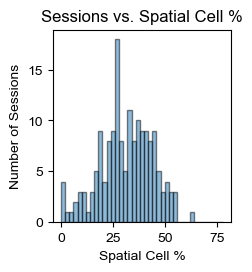

In [15]:
''' Examine spatial cell densities quickly as a sanity check across age groups'''

# Assess distribution of spatial/ngs cell densities
print('Mean, SEM Spatial Cell %')
print(np.mean(perspatial), stats.sem(perspatial))

#plot spatial cell % distributions
fig, ax = plt.subplots(1,1,figsize = (2.3,2.5), sharey = True)
ax.hist(perspatial, bins = np.arange(0,80,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax.set_title('Sessions vs. Spatial Cell %')
ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Spatial Cell %')

plt.show()

In [16]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [17]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# set up handles
from itertools import repeat
per99 = [mperspatial[y_ind], mperspatial[ma_ind], mperspatial[age_ind]]
handles = []

for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

# Classify non-grid spatial vs. grid cells or load classification.

In [29]:
'''Classify grid vs. non-grid cells at P99 peak height threshold and with FR thresholds & save results.

Run time < 1 min / session (167 sessions). If you have preiously run this, skip ahead to the next cell to load results.

'''

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

perngs = []
pergrid = []
for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        Aidx = d['Aidx']
        Bidx = d['Bidx']
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b=2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        
        #load in spatial cells & interneurons classified elsewhere
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        intn = d['intn']
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        peak = [] # boolean if peak found
        maxpeak_locs = [] #stored lag of max peak if peak exist
        maxpeak_heights = [] # stored height of max peak, otherwise 0 if not exist
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            autocorrelation = get.autocorr(FR[sdx,:], lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]
            heights = properties["peak_heights"]

            if peaks.size > 0:
                peak = np.append(peak,1)
                maxpeak_locs = np.append(maxpeak_locs, peaks[np.argmax(proms)])
                maxpeak_heights = np.append(maxpeak_heights, heights[np.argmax(proms)])
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                peak = np.append(peak,0)
                maxpeak_heights = np.append(maxpeak_heights,0)
                maxpeak_proms = np.append(maxpeak_proms,0)         
        peak = peak.astype(bool)
        
        #define low FR cell group (mean FR <0.05 in the dark; 0.3 Hz overall); to be removed from grid cell group
        stop_idx = np.where(trial <= 19)[0][-1].astype(int)
        darkFR, _ , _ = ps.tuning_curve_bytrial(posxfil[:stop_idx], trial[:stop_idx], Y[:stop_idx,:], dt, sigma = 2, b = 2, smooth=True, normalize=False, occupancy=True)
        FR, _, _ = ps.tuning_curve(posxfil, Y, dt, b=2, smooth=True, l=2, SEM=False, occupancy=False)
        lowfrcells = []
        lowdarkfrcells = []
        for i, c in enumerate(cell_IDs):
            if np.mean(np.mean(darkFR[:,:,i], axis = 1)) <= 0.05:
                lowdarkfrcells = np.append(lowdarkfrcells, c)
            elif np.mean(FR[:,i]) < 0.3:
                lowfrcells = np.append(lowfrcells, c)      
                
        #define indices excluding reward zone starts
        reward = raw.item().get('reward')
        centers = reward['centers']
        centera = centers[0]
        if centera == 270:
            centerb = 370
        else:
            centerb = 270
        
        # generate aligned position tuning curve
        aFR, abinned_pos, aFR_sem, occ = ps.tuning_curve(posxfil[Aidx], Y[Aidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        bFR, bbinned_pos, bFR_sem, occ = ps.tuning_curve(posxfil[Bidx], Y[Bidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        
        #find indices of bins not including 50cm pre-post reward centers (220 to 255 and 320 to 355)
        aidx = np.where((abinned_pos > (centera - 50)) & (abinned_pos <= (centera - 15)))
        maska = np.ones(len(abinned_pos), bool)
        maska[aidx] = 0
        bidx = np.where((bbinned_pos > (centerb - 50)) & (bbinned_pos <= (centerb - 15)))
        maskb = np.ones(len(bbinned_pos), bool)
        maskb[bidx] = 0
        
        noisycells = []
        for i, c in enumerate(cell_IDs):
            if (np.mean(aFR_sem[maska,i]) > np.mean(aFR[maska,i])*.45) and (np.mean(bFR_sem[maskb,i]) > np.mean(bFR[maskb,i])*.45):
                noisycells = np.append(noisycells, c)
        
        #classify grid cells based on peak prominence > P99 shuffle height
        shufmaxpeak_heights_file = 'shufmaxpeak_heights__' + m + '_' + s + '.npy'
        shuffmaxpeak_heights = np.load(shuffload_folder3 + shufmaxpeak_heights_file)
    
        gridcell = []
        for i, c in enumerate(cell_IDs):
            #require that grid cells have at least one peak larger than 0.15 prominence, height 0.1, width = 10 in the dark
            #also require that prom of peak exceeds P99 of shuffle autocorrelation height distribution autocorrelations at that same lag
            #also require that that cell is not an interneuron
    
            if (intn[i] == 0) & (peak[i] == 1):
                idx = np.where(cell_IDs[peak] == c)[0][0]
                dist = shuffmaxpeak_heights[:,idx]
                P99 = np.percentile(dist,99)

                if (maxpeak_proms[i] >= P99):
                    gridcell = np.append(gridcell, 1)
                else:
                    gridcell = np.append(gridcell, 0)
            else: 
                gridcell = np.append(gridcell, 0)
                
        #Find non-distance coding spatial cells to be ngs cells; then further            
        ngscell = []
        for i, c in enumerate(cell_IDs):
            #ngs cells are any spatial cells that do not meet distance-coding cell criteria or meet that criteria with a
            #very low dark FR 
            if (intn[i] == 1) | (gridcell[i] == 1) | (spatialcell99[i] == 0):
                ngscell = np.append(ngscell, 0)
            elif (peak[i] == 1): #remove any low quality grid cells that have a peak 
                idx = np.where(cell_IDs[peak] == c)[0][0]
                P90 = np.percentile(dist, 90)
                
                if (maxpeak_proms[i] >= P90) & (maxpeak_proms[i] < P99):
                    ngscell = np.append(ngscell, 0)
                elif (intn[i] == 0) & (gridcell[i] == 0) & (spatialcell99[i] == 1): 
                    ngscell = np.append(ngscell, 1)
                else: 
                    ngsell = np.append(ngscell, 0)
            elif (c not in lowdarkfrcells) & (peak[i] == 0) & (intn[i] == 0) & (spatialcell99[i] == 1):
                ngscell = np.append(ngscell, 1)
            else: 
                ngscell = np.append(ngscell, 0)
                
        # filter out noisy cells from both grid and ngs cells and low firing grid cells    
        for i, c in enumerate(cell_IDs):
            #also require that dark FR > 0.05 Hz and mean FR > 0.3 Hz
            if (c in lowfrcells) or (c in lowdarkfrcells):
                gridcell[i] = 0
                
            if (c in noisycells):
                gridcell[i] = 0
                ngscell[i] = 0
                
        #Save booleans
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        np.save(save_folder + gridcell_file, gridcell.astype(bool))
        #print('saved grid cell boolean for spatial cells as npy file for mouse ' + m + ' session '+ s)
                
        ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        np.save(save_folder + ngscell_file, d['ngscell'])
        #print('saved ngs cell boolean for spatial cells as npy file for mouse ' + m + ' session '+ s)

        #save percentages of grid vs. ngs cells
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\Desktop\GitHub\Herber2024\pipeline\get_data.py:380: RuntimeWarning: invalid value encountered in divide
  corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)


A14, 083022_record1 n grid, ngs cells: 8 , 50
A14, 083122_record2 n grid, ngs cells: 35 , 2
A14, 090122_record3 n grid, ngs cells: 17 , 13


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 4 , 6
A15, 083122_record2 n grid, ngs cells: 86 , 33
A15, 090122_record3 n grid, ngs cells: 89 , 37
A15, 090222_record4 n grid, ngs cells: 128 , 65
A15, 090322_record5 n grid, ngs cells: 37 , 30
A15, 090422_record6 n grid, ngs cells: 24 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 19 , 23
A16, 083122_record2 n grid, ngs cells: 60 , 36
A16, 090122_record3 n grid, ngs cells: 0 , 1
A16, 090222_record4 n grid, ngs cells: 12 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 1 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 6
A17, 082522_record3 n grid, ngs cells: 40 , 35
A17, 082622_record4 n grid, ngs cells: 42 , 17
A17, 082722_record5 n grid, ngs cells: 32 , 21
A17, 082822_record6 n grid, ngs cells: 54 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 13 , 10
A18, 082422_record2 n grid, ngs cells: 66 , 169
A18, 082522_record3 n grid, ngs cells: 68 , 117
A18, 082622_record4 n grid, ngs cells: 44 , 64
A18, 082722_record5 n grid, ngs cells: 47 , 10
A18, 082822_record6 n grid, ngs cells: 0 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 17 , 1
A19, 012823_record3 n grid, ngs cells: 22 , 75
A19, 012923_record4 n grid, ngs cells: 34 , 64
A19, 013023_record5 n grid, ngs cells: 54 , 38
A19, 013123_record6 n grid, ngs cells: 35 , 18
A19, 020123_record7 n grid, ngs cells: 54 , 31


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 3 , 18
A20, 012723_record2 n grid, ngs cells: 24 , 50
A20, 012823_record3 n grid, ngs cells: 69 , 56
A20, 012923_record4 n grid, ngs cells: 21 , 42
A20, 013023_record5 n grid, ngs cells: 22 , 55
A20, 013123_record6 n grid, ngs cells: 9 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 58 , 39
A22, 013023_record3 n grid, ngs cells: 79 , 122
A22, 013123_record4 n grid, ngs cells: 55 , 46
A22, 020123_record5 n grid, ngs cells: 10 , 12
A22, 020223_record6 n grid, ngs cells: 31 , 38
A22, 020323_record7 n grid, ngs cells: 12 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 4 , 10
A23, 021023_record2 n grid, ngs cells: 27 , 63
A23, 021123_record3 n grid, ngs cells: 29 , 66
A23, 021223_record4 n grid, ngs cells: 9 , 3
A23, 021323_record5 n grid, ngs cells: 27 , 38
A23, 021423_record6 n grid, ngs cells: 50 , 54


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 41 , 34
A24, 022723_record2 n grid, ngs cells: 108 , 65
A24, 022823_record3 n grid, ngs cells: 61 , 63
A24, 030123_record4 n grid, ngs cells: 66 , 37
A24, 030223_record5 n grid, ngs cells: 53 , 26
A24, 030323_record6 n grid, ngs cells: 20 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 69 , 91
MA10F, 111422_record2 n grid, ngs cells: 52 , 48
MA10F, 111522_record3 n grid, ngs cells: 38 , 24
MA10F, 111622_record4 n grid, ngs cells: 19 , 24
MA10F, 111722_record5 n grid, ngs cells: 17 , 28
MA10F, 111822_record6 n grid, ngs cells: 39 , 61


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 33 , 25
MA1F, 102422_record2 n grid, ngs cells: 53 , 28
MA1F, 102522_record3 n grid, ngs cells: 48 , 21
MA1F, 102622_record4 n grid, ngs cells: 9 , 8
MA1F, 102722_record5 n grid, ngs cells: 71 , 52
MA1F, 102822_record6 n grid, ngs cells: 72 , 28


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 47 , 76
MA2F, 102422_record2 n grid, ngs cells: 38 , 103
MA2F, 102522_record3 n grid, ngs cells: 50 , 110
MA2F, 102622_record4 n grid, ngs cells: 39 , 65
MA2F, 102722_record5 n grid, ngs cells: 38 , 43
MA2F, 102822_record6 n grid, ngs cells: 40 , 49


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 6 , 22
MA3M, 102422_record2 n grid, ngs cells: 28 , 53
MA3M, 102522_record3 n grid, ngs cells: 36 , 47
MA3M, 102622_record4 n grid, ngs cells: 13 , 55
MA3M, 102722_record5 n grid, ngs cells: 12 , 30
MA3M, 102822_record6 n grid, ngs cells: 31 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 24 , 68
MA4M, 110122_record3 n grid, ngs cells: 29 , 27
MA4M, 110222_record4 n grid, ngs cells: 8 , 13
MA4M, 110322_record5rep n grid, ngs cells: 26 , 18
MA4M, 110422_record6 n grid, ngs cells: 36 , 35
MA4M, 110522_record7 n grid, ngs cells: 12 , 9


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 58 , 30
MA5M, 110722_record2 n grid, ngs cells: 62 , 55
MA5M, 110822_record3 n grid, ngs cells: 79 , 30
MA5M, 110922_record4 n grid, ngs cells: 7 , 11
MA5M, 111022_record5 n grid, ngs cells: 23 , 25
MA5M, 111122_record6 n grid, ngs cells: 22 , 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 22 , 75
MA6M, 103122_record2 n grid, ngs cells: 17 , 39
MA6M, 110122_record3 n grid, ngs cells: 64 , 66
MA6M, 110222_record4 n grid, ngs cells: 7 , 13
MA6M, 110322_record5 n grid, ngs cells: 10 , 6
MA6M, 110422_record6 n grid, ngs cells: 39 , 31


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 31 , 36
MA7M, 103122_record2 n grid, ngs cells: 32 , 56
MA7M, 110122_record3 n grid, ngs cells: 19 , 28
MA7M, 110222_record4 n grid, ngs cells: 7 , 7


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 19 , 8
MA8F, 111422_record2 n grid, ngs cells: 62 , 67
MA8F, 111522_record3 n grid, ngs cells: 80 , 26
MA8F, 111622_record4 n grid, ngs cells: 25 , 37
MA8F, 111722_record5 n grid, ngs cells: 10 , 29
MA8F, 111822_record6 n grid, ngs cells: 12 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 56 , 29
MA9F, 111422_record2 n grid, ngs cells: 73 , 169
MA9F, 111522_record3 n grid, ngs cells: 119 , 80
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 24 , 34
MA9F, 111822_record6 n grid, ngs cells: 23 , 16


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 7 , 7
Y20, 092622_record2 n grid, ngs cells: 32 , 39
Y20, 092722_record3 n grid, ngs cells: 13 , 10
Y20, 092822_record4 n grid, ngs cells: 51 , 33
Y20, 092922_record5 n grid, ngs cells: 19 , 14
Y20, 093022_record6 n grid, ngs cells: 85 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 103 , 76
Y21, 091922_record2 n grid, ngs cells: 80 , 93
Y21, 092022_record3 n grid, ngs cells: 49 , 23
Y21, 092122_record4 n grid, ngs cells: 60 , 62
Y21, 092222_record5 n grid, ngs cells: 42 , 50
Y21, 092322_record6 n grid, ngs cells: 8 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 85 , 57
Y22, 092622_record2 n grid, ngs cells: 146 , 66
Y22, 092722_record3 n grid, ngs cells: 60 , 84
Y22, 092822_record4 n grid, ngs cells: 24 , 21
Y22, 092922_record5 n grid, ngs cells: 20 , 25
Y22, 093022_record6 n grid, ngs cells: 60 , 36


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 38 , 27
Y23, 092622_record2 n grid, ngs cells: 33 , 23
Y23, 092722_record3 n grid, ngs cells: 30 , 40
Y23, 092822_record4 n grid, ngs cells: 26 , 32
Y23, 092922_record5 n grid, ngs cells: 41 , 49
Y23, 093022_record6 n grid, ngs cells: 60 , 84


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 91 , 64
Y24, 091922_record2 n grid, ngs cells: 28 , 69
Y24, 092022_record3 n grid, ngs cells: 97 , 49
Y24, 092122_record4 n grid, ngs cells: 94 , 64
Y24, 092222_record5 n grid, ngs cells: 66 , 44
Y24, 092322_record6 n grid, ngs cells: 70 , 43


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 85 , 37
Y25, 021823_record3 n grid, ngs cells: 29 , 64
Y25, 021923_record4 n grid, ngs cells: 38 , 49
Y25, 022023_record5 n grid, ngs cells: 49 , 46
Y25, 022123_record6 n grid, ngs cells: 18 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 34 , 47
Y26, 021723_record2 n grid, ngs cells: 51 , 22
Y26, 021823_record3 n grid, ngs cells: 23 , 32
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 17 , 19
Y26, 022123_record6 n grid, ngs cells: 4 , 3


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 53 , 44
Y27, 021723_record2 n grid, ngs cells: 39 , 17
Y27, 021823_record3 n grid, ngs cells: 31 , 18
Y27, 021923_record4 n grid, ngs cells: 19 , 20
Y27, 022023_record5rep n grid, ngs cells: 48 , 26
Y27, 022123_record6 n grid, ngs cells: 65 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 4 , 32
Y28, 022723_record2 n grid, ngs cells: 41 , 58
Y28, 022823_record3 n grid, ngs cells: 48 , 45
Y28, 030123_record4 n grid, ngs cells: 20 , 33
Y28, 030223_record5 n grid, ngs cells: 40 , 75
Y28, 030323_record6 n grid, ngs cells: 65 , 48


# If you've run the cells above before, run the one below to load grid and non-grid spatial cells.

In [18]:
''' If you have previously classified grid & ngs cells, run this cell to load saved grid & ngs cell booleans. '''

pergrid = []
perngs = []

spergrid = []
sperngs = []
mpergrid = []

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all grid cell boolean
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        gridcell = np.load(save_folder + gridcell_file)
        
        ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        ngscell = np.load(save_folder + ngscell_file)
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        sperngs = np.append(sperngs, 100*np.sum(ngscell)/len(cell_IDs))
        spergrid = np.append(spergrid, 100*np.sum(gridcell)/len(cell_IDs))
        m_pergrid = np.append(m_pergrid, np.sum(gridcell))
        m_cells = np.append(m_cells, len(cell_IDs))
      
    mpergrid = np.append(mpergrid, np.sum(m_pergrid)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 8 , 50
A14, 083122_record2 n grid, ngs cells: 35 , 2
A14, 090122_record3 n grid, ngs cells: 17 , 13


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 4 , 6
A15, 083122_record2 n grid, ngs cells: 86 , 33
A15, 090122_record3 n grid, ngs cells: 89 , 37
A15, 090222_record4 n grid, ngs cells: 128 , 65
A15, 090322_record5 n grid, ngs cells: 37 , 30
A15, 090422_record6 n grid, ngs cells: 24 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 19 , 23
A16, 083122_record2 n grid, ngs cells: 60 , 36
A16, 090122_record3 n grid, ngs cells: 0 , 1
A16, 090222_record4 n grid, ngs cells: 12 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 1 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 6
A17, 082522_record3 n grid, ngs cells: 40 , 35
A17, 082622_record4 n grid, ngs cells: 42 , 17
A17, 082722_record5 n grid, ngs cells: 32 , 21
A17, 082822_record6 n grid, ngs cells: 54 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 13 , 10
A18, 082422_record2 n grid, ngs cells: 66 , 169
A18, 082522_record3 n grid, ngs cells: 68 , 117
A18, 082622_record4 n grid, ngs cells: 44 , 64
A18, 082722_record5 n grid, ngs cells: 47 , 10
A18, 082822_record6 n grid, ngs cells: 0 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 17 , 1
A19, 012823_record3 n grid, ngs cells: 22 , 75
A19, 012923_record4 n grid, ngs cells: 34 , 64
A19, 013023_record5 n grid, ngs cells: 54 , 38
A19, 013123_record6 n grid, ngs cells: 35 , 18
A19, 020123_record7 n grid, ngs cells: 54 , 31


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 3 , 18
A20, 012723_record2 n grid, ngs cells: 24 , 50
A20, 012823_record3 n grid, ngs cells: 69 , 56
A20, 012923_record4 n grid, ngs cells: 21 , 42
A20, 013023_record5 n grid, ngs cells: 22 , 55
A20, 013123_record6 n grid, ngs cells: 9 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 58 , 39
A22, 013023_record3 n grid, ngs cells: 79 , 122
A22, 013123_record4 n grid, ngs cells: 55 , 46
A22, 020123_record5 n grid, ngs cells: 10 , 12
A22, 020223_record6 n grid, ngs cells: 31 , 38
A22, 020323_record7 n grid, ngs cells: 12 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 4 , 10
A23, 021023_record2 n grid, ngs cells: 27 , 63
A23, 021123_record3 n grid, ngs cells: 29 , 66
A23, 021223_record4 n grid, ngs cells: 9 , 3
A23, 021323_record5 n grid, ngs cells: 27 , 38
A23, 021423_record6 n grid, ngs cells: 50 , 54


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 41 , 34
A24, 022723_record2 n grid, ngs cells: 108 , 65
A24, 022823_record3 n grid, ngs cells: 61 , 63
A24, 030123_record4 n grid, ngs cells: 66 , 37
A24, 030223_record5 n grid, ngs cells: 53 , 26
A24, 030323_record6 n grid, ngs cells: 20 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 69 , 91
MA10F, 111422_record2 n grid, ngs cells: 52 , 48
MA10F, 111522_record3 n grid, ngs cells: 38 , 24
MA10F, 111622_record4 n grid, ngs cells: 19 , 24
MA10F, 111722_record5 n grid, ngs cells: 17 , 28
MA10F, 111822_record6 n grid, ngs cells: 39 , 61


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 33 , 25
MA1F, 102422_record2 n grid, ngs cells: 53 , 28
MA1F, 102522_record3 n grid, ngs cells: 48 , 21
MA1F, 102622_record4 n grid, ngs cells: 9 , 8
MA1F, 102722_record5 n grid, ngs cells: 71 , 52
MA1F, 102822_record6 n grid, ngs cells: 72 , 28


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 47 , 76
MA2F, 102422_record2 n grid, ngs cells: 38 , 103
MA2F, 102522_record3 n grid, ngs cells: 50 , 110
MA2F, 102622_record4 n grid, ngs cells: 39 , 65
MA2F, 102722_record5 n grid, ngs cells: 38 , 43
MA2F, 102822_record6 n grid, ngs cells: 40 , 49


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 6 , 22
MA3M, 102422_record2 n grid, ngs cells: 28 , 53
MA3M, 102522_record3 n grid, ngs cells: 36 , 47
MA3M, 102622_record4 n grid, ngs cells: 13 , 55
MA3M, 102722_record5 n grid, ngs cells: 12 , 30
MA3M, 102822_record6 n grid, ngs cells: 31 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 24 , 68
MA4M, 110122_record3 n grid, ngs cells: 29 , 27
MA4M, 110222_record4 n grid, ngs cells: 8 , 13
MA4M, 110322_record5rep n grid, ngs cells: 26 , 18
MA4M, 110422_record6 n grid, ngs cells: 36 , 35
MA4M, 110522_record7 n grid, ngs cells: 12 , 9


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 58 , 30
MA5M, 110722_record2 n grid, ngs cells: 62 , 55
MA5M, 110822_record3 n grid, ngs cells: 79 , 30
MA5M, 110922_record4 n grid, ngs cells: 7 , 11
MA5M, 111022_record5 n grid, ngs cells: 23 , 25
MA5M, 111122_record6 n grid, ngs cells: 22 , 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 22 , 75
MA6M, 103122_record2 n grid, ngs cells: 17 , 39
MA6M, 110122_record3 n grid, ngs cells: 64 , 66
MA6M, 110222_record4 n grid, ngs cells: 7 , 13
MA6M, 110322_record5 n grid, ngs cells: 10 , 6
MA6M, 110422_record6 n grid, ngs cells: 39 , 31


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 31 , 36
MA7M, 103122_record2 n grid, ngs cells: 32 , 56
MA7M, 110122_record3 n grid, ngs cells: 19 , 28
MA7M, 110222_record4 n grid, ngs cells: 7 , 7


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 19 , 8
MA8F, 111422_record2 n grid, ngs cells: 62 , 67
MA8F, 111522_record3 n grid, ngs cells: 80 , 26
MA8F, 111622_record4 n grid, ngs cells: 25 , 37
MA8F, 111722_record5 n grid, ngs cells: 10 , 29
MA8F, 111822_record6 n grid, ngs cells: 12 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 56 , 29
MA9F, 111422_record2 n grid, ngs cells: 73 , 169
MA9F, 111522_record3 n grid, ngs cells: 119 , 80
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 24 , 34
MA9F, 111822_record6 n grid, ngs cells: 23 , 16


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 7 , 7
Y20, 092622_record2 n grid, ngs cells: 32 , 39
Y20, 092722_record3 n grid, ngs cells: 13 , 10
Y20, 092822_record4 n grid, ngs cells: 51 , 33
Y20, 092922_record5 n grid, ngs cells: 19 , 14
Y20, 093022_record6 n grid, ngs cells: 85 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 103 , 76
Y21, 091922_record2 n grid, ngs cells: 80 , 93
Y21, 092022_record3 n grid, ngs cells: 49 , 23
Y21, 092122_record4 n grid, ngs cells: 60 , 62
Y21, 092222_record5 n grid, ngs cells: 42 , 50
Y21, 092322_record6 n grid, ngs cells: 8 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 85 , 57
Y22, 092622_record2 n grid, ngs cells: 146 , 66
Y22, 092722_record3 n grid, ngs cells: 60 , 84
Y22, 092822_record4 n grid, ngs cells: 24 , 21
Y22, 092922_record5 n grid, ngs cells: 20 , 25
Y22, 093022_record6 n grid, ngs cells: 60 , 36


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 38 , 27
Y23, 092622_record2 n grid, ngs cells: 33 , 23
Y23, 092722_record3 n grid, ngs cells: 30 , 40
Y23, 092822_record4 n grid, ngs cells: 26 , 32
Y23, 092922_record5 n grid, ngs cells: 41 , 49
Y23, 093022_record6 n grid, ngs cells: 60 , 84


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 91 , 64
Y24, 091922_record2 n grid, ngs cells: 28 , 69
Y24, 092022_record3 n grid, ngs cells: 97 , 49
Y24, 092122_record4 n grid, ngs cells: 94 , 64
Y24, 092222_record5 n grid, ngs cells: 66 , 44
Y24, 092322_record6 n grid, ngs cells: 70 , 43


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 85 , 37
Y25, 021823_record3 n grid, ngs cells: 29 , 64
Y25, 021923_record4 n grid, ngs cells: 38 , 49
Y25, 022023_record5 n grid, ngs cells: 49 , 46
Y25, 022123_record6 n grid, ngs cells: 18 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 34 , 47
Y26, 021723_record2 n grid, ngs cells: 51 , 22
Y26, 021823_record3 n grid, ngs cells: 23 , 32
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 17 , 19
Y26, 022123_record6 n grid, ngs cells: 4 , 3


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 53 , 44
Y27, 021723_record2 n grid, ngs cells: 39 , 17
Y27, 021823_record3 n grid, ngs cells: 31 , 18
Y27, 021923_record4 n grid, ngs cells: 19 , 20
Y27, 022023_record5rep n grid, ngs cells: 48 , 26
Y27, 022123_record6 n grid, ngs cells: 65 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 4 , 32
Y28, 022723_record2 n grid, ngs cells: 41 , 58
Y28, 022823_record3 n grid, ngs cells: 48 , 45
Y28, 030123_record4 n grid, ngs cells: 20 , 33
Y28, 030223_record5 n grid, ngs cells: 40 , 75
Y28, 030323_record6 n grid, ngs cells: 65 , 48


# Assess grid and non-grid spatial cell density among spatial cells.

In [19]:
''' Get counts of grid vs ngs cells by age group '''

ygrid = 0
magrid = 0
agrid = 0

yngs = 0
mangs = 0
angs = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        gridcell = d['gridcell']
        ngscell = d['ngscell']
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        
        if m in SM_aged_mice:
            agrid += np.sum(gridcell)
            angs += np.sum(ngscell)
        elif m in SM_MA_mice:
            magrid += np.sum(gridcell)
            mangs += np.sum(ngscell)
        else:
            ygrid += np.sum(gridcell)
            yngs += np.sum(ngscell)
            
print(ygrid, magrid, agrid)
print(yngs, mangs, angs)

2441 2035 2032
2154 2347 2058


Mean, SEM Grid Cell %; Mean, Sem NGS Cell %
14.8296889586848 0.6177677242640354 15.167797844277539 0.5583139064062825


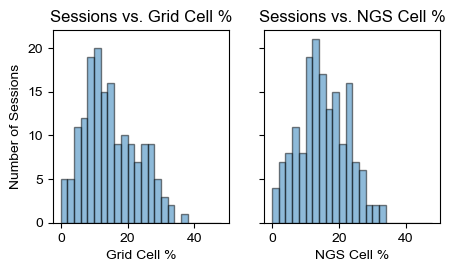

In [20]:
''' Examine grid & NGS cell densities quickly as a sanity check across age groups'''

# Assess distribution of grid/ngs cell densities
print('Mean, SEM Grid Cell %; Mean, Sem NGS Cell %')
print(np.mean(pergrid), stats.sem(pergrid), np.mean(perngs), stats.sem(perngs))

#plot grid vs. ngs cell % distributions
fig, ax = plt.subplots(1,2,figsize = (5,2.5), sharey = True)
ax[0].hist(pergrid, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[0].set_title('Sessions vs. Grid Cell %')
ax[0].set_ylabel('Number of Sessions')
ax[0].set_xlabel('Grid Cell %')

ax[1].hist(perngs, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[1].set_title('Sessions vs. NGS Cell %')
ax[1].set_xlabel('NGS Cell %')

plt.show()

In [25]:
''' Get % grid / ngs that are also spatial by session'''

sperspatialgrid = []
sperspatialngs = []
spergridspatial = []
sperngsspatial = []

totalnonspatialgrid_y = 0
totalnonspatialgrid_ma = 0
totalnonspatialgrid_aged = 0

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        spatialgridcells = []
        spatialngscells = []
        for i, c in enumerate(cell_IDs):
            if (c in spatialcells) & (c in gridcells):
                spatialgridcells = np.append(spatialgridcells, c)
                
            if (c in gridcells) & (c not in spatialcells):
                if m in SM_aged_mice:
                    totalnonspatialgrid_aged += 1
                elif m in SM_MA_mice:
                    totalnonspatialgrid_ma += 1
                else:
                    totalnonspatialgrid_y += 1
            
            if (c in spatialcells) & (c in ngscells):
                spatialngscells = np.append(spatialngscells, c)            
        
        if len(ngscells) > 0:
            sperspatialngs = np.append(sperspatialngs, 100*len(spatialngscells)/len(ngscells))
        else:
            sperspatialngs = np.append(sperspatialngs, np.nan)
         
        if len(gridcells) > 0:
            sperspatialgrid = np.append(sperspatialgrid, 100*len(spatialgridcells)/len(gridcells))
             
            #Print Extended Data Figure 2a Source Data
            #print(str(m) + ',' + str(np.mean(100*len(spatialcells)/len(cell_IDs))) + ',' + str(100*len(spatialgridcells)/len(spatialcells)) + ',' + str(100*len(spatialngscells)/len(spatialcells)) + ',' + str(100*len(spatialgridcells)/len(spatialcells) + 100*len(spatialngscells)/len(spatialcells))  + ',' + str(100*len(spatialgridcells)/len(gridcells)))
        
        else:
            sperspatialgrid = np.append(sperspatialgrid, np.nan)
            
            #Print Extended Data Figure 2a Source Data
            #print(str(m) + ',' + str(np.mean(100*len(spatialcells)/len(cell_IDs))) + ',' + str(100*len(spatialgridcells)/len(spatialcells)) + ',' + str(100*len(spatialngscells)/len(spatialcells)) + ',' + str(100*len(spatialgridcells)/len(spatialcells) + 100*len(spatialngscells)/len(spatialcells))  + ',' + str(np.nan))
            
        if len(spatialcells) > 0:
            sperngsspatial = np.append(sperngsspatial, 100*len(spatialngscells)/len(spatialcells))
            spergridspatial = np.append(spergridspatial, 100*len(spatialgridcells)/len(spatialcells))
        else:
            sperngsspatial = np.append(sperngsspatial, np.nan)
            spergridspatial = np.append(spergridspatial, np.nan)

# Plot Extended Data Fig. 2A Panels (Far Left to Far Right)

S2A was also included in Reviewer Figure 4.

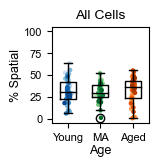


Among all cells results:
% spatial young mean ± SEM; % spatial MA mean ± SEM; % spatial aged mean ± SEM
31.9 ± 1.86 ; 30.32 ± 1.3 ; 31.62 ± 1.91
H = 1.1066008273835568
p = 0.5750487761521565
n young, MA, aged SM sessions:
54 58 55


In [35]:
'''Plot Extended Data Fig. 2A Far Left '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [sperspatial[y_sind],sperspatial[ma_sind],sperspatial[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Spatial', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)
ax.set_title('All Cells', fontsize = 10)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'S2Afarleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2Afarleft.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nAmong all cells results:')
print('% spatial young mean ± SEM; % spatial MA mean ± SEM; % spatial aged mean ± SEM')
print(str(np.round(np.mean(sperspatial[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatial[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatial[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatial[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatial[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatial[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperspatial[y_sind],sperspatial[ma_sind],sperspatial[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

print('n young, MA, aged SM sessions:')
print(len(y_sind), len(ma_sind), len(age_sind))

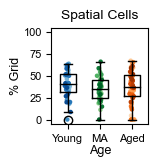


Among spatial cell results:
% grid young mean ± SEM; % grid MA mean ± SEM; % grid aged mean ± SEM
40.56 ± 1.97 ; 35.22 ± 1.73 ; 36.76 ± 2.46
H = 4.085436999287678
p = 0.12967570791083297


In [36]:
'''Plot Extended Data Fig. 2A Middle Left '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [spergridspatial[y_sind],spergridspatial[ma_sind],spergridspatial[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_title('Spatial Cells', fontsize=10)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Grid', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'S2Amiddleleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2Amiddleleft.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nAmong spatial cell results:')
print('% grid young mean ± SEM; % grid MA mean ± SEM; % grid aged mean ± SEM')
print(str(np.round(np.mean(spergridspatial[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergridspatial[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergridspatial[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergridspatial[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergridspatial[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergridspatial[age_sind]), 2)))

stat, p_diff = stats.kruskal(spergridspatial[y_sind],spergridspatial[ma_sind],spergridspatial[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

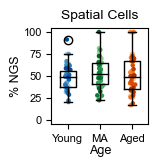


Among spatial cell results:
% NGS young mean ± SEM; % NGS MA mean ± SEM; % NGS aged mean ± SEM
47.59 ± 1.86 ; 52.29 ± 2.14 ; 50.49 ± 2.67
H = 2.6475967498657536
p = 0.2661225465611879


In [37]:
'''Plot Extended Data Fig. 2A Middle '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [sperngsspatial[y_sind],sperngsspatial[ma_sind],sperngsspatial[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_title('Spatial Cells', fontsize=10)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% NGS', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'S2Amiddle.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2Amiddle.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nAmong spatial cell results:')
print('% NGS young mean ± SEM; % NGS MA mean ± SEM; % NGS aged mean ± SEM')
print(str(np.round(np.mean(sperngsspatial[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngsspatial[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngsspatial[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperngsspatial[y_sind],sperngsspatial[ma_sind],sperngsspatial[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

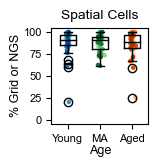


Among spatial cell results:
% grid or NGS young mean ± SEM; % MA mean ± SEM; % aged mean ± SEM
88.16 ± 1.75 ; 87.5 ± 1.24 ; 87.24 ± 1.76
H = 0.8191218898576432
p = 0.6639416931192086


In [38]:
'''Plot Extended Data Fig. 2A Middle Right '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [sperngsspatial[y_sind] + spergridspatial[y_sind],sperngsspatial[ma_sind] + spergridspatial[ma_sind],sperngsspatial[age_sind] + spergridspatial[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_title('Spatial Cells', fontsize=10)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Grid or NGS', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'S2Amiddleright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2Amiddleright.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nAmong spatial cell results:')
print('% grid or NGS young mean ± SEM; % MA mean ± SEM; % aged mean ± SEM')
print(str(np.round(np.mean(sperngsspatial[y_sind] + spergridspatial[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[y_sind] + spergridspatial[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngsspatial[ma_sind] + spergridspatial[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[ma_sind] + spergridspatial[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngsspatial[age_sind] + spergridspatial[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngsspatial[age_sind] + spergridspatial[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperngsspatial[y_sind] + spergridspatial[y_sind],sperngsspatial[ma_sind] + spergridspatial[ma_sind],sperngsspatial[age_sind] + spergridspatial[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

In [40]:
''' Find where I will have NaNs for Sessions w/o Grid & NGS Cells'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55


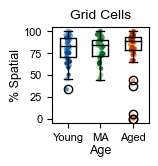


Among grid cell results:
% spatial young mean ± SEM; % MA mean ± SEM; % old mean ± SEM
80.31 ± 2.08 ; 80.42 ± 1.83 ; 80.37 ± 3.16
H = 1.9633448386650865
p = 0.37468394589150783

n young, MA, aged sessions w/ grid cells: 
53 57 53

total number of non-spatial grid cells (young, MA, aged): 
400 394 299


In [41]:
'''Plot Extended Data Fig. 2A Far Right'''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [sperspatialgrid[y_sindgrid],sperspatialgrid[ma_sindgrid],sperspatialgrid[age_sindgrid]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_title('Grid Cells', fontsize=10)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Spatial', fontsize=9, labelpad=1)
ax.set_ylim([-5,105])
ax.set_yticks([0,25,50,75,100])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid[i], edgecolors = col_sessiongrid[i], alpha = 1, s = 5)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'S2Afarright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2Afarright.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nAmong grid cell results:')
print('% spatial young mean ± SEM; % MA mean ± SEM; % old mean ± SEM')
print(str(np.round(np.mean(sperspatialgrid[y_sindgrid]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatialgrid[y_sindgrid]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatialgrid[ma_sindgrid]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatialgrid[ma_sindgrid]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatialgrid[age_sindgrid]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatialgrid[age_sindgrid]), 2)))

stat, p_diff = stats.kruskal(sperspatialgrid[y_sindgrid],sperspatialgrid[ma_sindgrid],sperspatialgrid[age_sindgrid])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

print('\nn young, MA, aged sessions w/ grid cells: ')
print(len(sperspatialgrid[y_sindgrid]), len(sperspatialgrid[ma_sindgrid]), len(sperspatialgrid[age_sindgrid]))

print('\ntotal number of non-spatial grid cells (young, MA, aged): ')
print(totalnonspatialgrid_y,totalnonspatialgrid_ma,totalnonspatialgrid_aged)

# Compare grid, non-grid spatial, spatial, & other EX cell spatial & distance tuning. Plot Extended Data Figs. 2B-C & related reviewer figure panel.

In [29]:
''' Gather Block A Coherence & Sparsity & Distance Tuning Across Cell Types by Session '''

sspatialc = []
sspatials = []
sspatiald = []
sNGSc = []
sNGSs = []
sNGSd = []
sgridc = []
sgrids = []
sgridd = []
sotherc = []
sothers = []
sotherd = []

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #Load data & scores
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores'] 

        #get cell IDs by group
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        #find "other" excitatory cells (non-spatial, non-grid)
        intn = d['intn'].astype(bool)
        INs = cell_IDs[intn]
    
        othercell = np.zeros(len(cell_IDs),bool)
        for i, c in enumerate(cell_IDs):
            
            if (c not in spatialcells) & (c not in gridcells) & (c not in INs):
                othercell[i] = 1
        
        d['othercell'] = othercell
        othercells = cell_IDs[othercell]
        #print('% other EX cells: ' + str(np.round(len(othercells)/len(cell_IDs)*100,2)))
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        
        #find distance tuning strength for all cells
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            autocorrelation = get.autocorr(FR[i,:], lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]

            if peaks.size > 0:
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                maxpeak_proms = np.append(maxpeak_proms,0)         
        
        #report scores for each group of cells
        spatialc = []
        spatials = []
        spatiald = []
        NGSc = []
        NGSs = []
        NGSd = []
        gridc = []
        grids = []
        gridd = []
        otherc = []
        others = []
        otherd = []
        for i, c in enumerate(cell_IDs):
        
            coherence = spatialacoherence_scores[i]
            sparsity = sparsitya_scores[i]
            distance = maxpeak_proms[i]
            
            if c in spatialcells:
                spatials = np.append(spatials,sparsity)
                spatialc = np.append(spatialc,coherence)
                spatiald = np.append(spatiald,distance)
                
            if c in ngscells:
                NGSs = np.append(NGSs,sparsity)
                NGSc = np.append(NGSc,coherence)
                NGSd = np.append(NGSd,distance)
                
            if c in othercells:
                others = np.append(others,sparsity)
                otherc = np.append(otherc,coherence)
                otherd = np.append(otherd,distance)
                
            if c in gridcells:
                grids = np.append(grids,sparsity)
                gridc = np.append(gridc,coherence)
                gridd = np.append(gridd,distance)
        
        #save results
        sspatialc = np.append(sspatialc, np.mean(spatialc))
        sspatials = np.append(sspatials, np.nanmean(spatials))
        sspatiald = np.append(sspatiald, np.mean(spatiald))
        sNGSc = np.append(sNGSc, np.mean(NGSc))
        sNGSs = np.append(sNGSs, np.nanmean(NGSs))
        sNGSd = np.append(sNGSd, np.mean(NGSd))
        if len(gridcells) > 0:
            sgridc = np.append(sgridc, np.mean(gridc))
            sgrids = np.append(sgrids, np.nanmean(grids))
            sgridd = np.append(sgridd, np.mean(gridd))
        else:
            sgridc = np.append(sgridc, np.nan)
            sgrids = np.append(sgrids, np.nan)
            sgridd = np.append(sgridd, np.nan)
        sotherc = np.append(sotherc, np.mean(otherc))
        sothers = np.append(sothers, np.nanmean(others))
        sotherd = np.append(sotherd, np.mean(otherd))
        
        #Print Source Data for Extended Data Fig. 2b
        #if len(gridcells) > 0:
            #print(str(m) + ',' + str('Grid') + ',' + str(np.mean(gridc)))
        #else:
            #print(str(m) + ',' + str('Grid') + ',' + str(np.nan))
            
        #print(str(m) + ',' + str('NGS') + ',' + str(np.mean(NGSc)))
        #print(str(m) + ',' + str('Spatial') + ',' + str(np.mean(spatialc))) 
        #print(str(m) + ',' + str('Other') + ',' + str(np.mean(otherc)))
        
        #Print Source Data for Extended Data Fig. 2c
        if len(gridcells) > 0:
            print(str(m) + ',' + str('Grid') + ',' + str(np.mean(gridd)))
        else:
            print(str(m) + ',' + str('Grid') + ',' + str(np.nan))
            
        print(str(m) + ',' + str('NGS') + ',' + str(np.mean(NGSd)))
        print(str(m) + ',' + str('Spatial') + ',' + str(np.mean(spatiald)))
        print(str(m) + ',' + str('Other') + ',' + str(np.mean(otherd)))

A14,Grid,0.2594991352908105
A14,NGS,0.0524132281616695
A14,Spatial,0.08555549594240666
A14,Other,0.09218193457454116
A14,Grid,0.25447408865407234
A14,NGS,0.1934496677476193
A14,Spatial,0.24362988656709506
A14,Other,0.10485817824955926
A14,Grid,0.2628605961005043
A14,NGS,0.14898828526180213
A14,Spatial,0.1897770280522221
A14,Other,0.04641108908069032
A15,Grid,0.1885375224778189
A15,NGS,0.0
A15,Spatial,0.06855909908284324
A15,Other,0.013031982841388403
A15,Grid,0.2384393825701701
A15,NGS,0.01702406094855772
A15,Spatial,0.16831698058597083
A15,Other,0.08241625140434829
A15,Grid,0.26231294283612017
A15,NGS,0.02288417418769537
A15,Spatial,0.18326737184673297
A15,Other,0.07730293480340077
A15,Grid,0.20534067626310828
A15,NGS,0.0023085422432791314
A15,Spatial,0.12586133267415464
A15,Other,0.05731539846072626
A15,Grid,0.26067617218807565
A15,NGS,0.023119448759591654
A15,Spatial,0.14038999012587117
A15,Other,0.05281774295543027
A15,Grid,0.32685854723862284
A15,NGS,0.06294488632904793
A15,Spatia

MA2F,Grid,0.20114896723193748
MA2F,NGS,0.04310212016156039
MA2F,Spatial,0.0945367341748063
MA2F,Other,0.06904890924367904
MA2F,Grid,0.21555229727303438
MA2F,NGS,0.03344766691736274
MA2F,Spatial,0.10502065556132287
MA2F,Other,0.06315876143753454
MA2F,Grid,0.2045049995336008
MA2F,NGS,0.043371820219122295
MA2F,Spatial,0.09998514725073769
MA2F,Other,0.039326919024347914
MA3M,Grid,0.20905570559316702
MA3M,NGS,0.06112865003773453
MA3M,Spatial,0.07452100256946685
MA3M,Other,0.06271126327473901
MA3M,Grid,0.1947009406965843
MA3M,NGS,0.019653290682967478
MA3M,Spatial,0.08507106856528848
MA3M,Other,0.0808697193711046
MA3M,Grid,0.1920392459140923
MA3M,NGS,0.028947954768323802
MA3M,Spatial,0.06827906263556542
MA3M,Other,0.05567551174041278
MA3M,Grid,0.20615737162560788
MA3M,NGS,0.04945796445270173
MA3M,Spatial,0.07976127676271687
MA3M,Other,0.05987286950418912
MA3M,Grid,0.19746831718288158
MA3M,NGS,0.03827987990863264
MA3M,Spatial,0.07986708524779951
MA3M,Other,0.08698999468543907
MA3M,Grid,0.19915

Y24,Grid,0.3082036772915219
Y24,NGS,0.033960247217437865
Y24,Spatial,0.20983943250049408
Y24,Other,0.07824746242444974
Y24,Grid,0.2943566403223561
Y24,NGS,0.050075734962347976
Y24,Spatial,0.1737319842700794
Y24,Other,0.03976938844675735
Y24,Grid,0.2672619553454582
Y24,NGS,0.010390317882970622
Y24,Spatial,0.1642247684210512
Y24,Other,0.0715028630766736
Y24,Grid,0.2680949376661796
Y24,NGS,0.01928929100622709
Y24,Spatial,0.164375323964895
Y24,Other,0.04198713826883886
Y25,Grid,nan
Y25,NGS,0.0
Y25,Spatial,0.03524985721681938
Y25,Other,0.032175234467426025
Y25,Grid,0.262391575389976
Y25,NGS,0.05476809199974422
Y25,Spatial,0.18993675121999581
Y25,Other,0.05825037394468512
Y25,Grid,0.22311410035269208
Y25,NGS,0.05429048323888712
Y25,Spatial,0.09638354150581163
Y25,Other,0.04946722292800571
Y25,Grid,0.21405170769127332
Y25,NGS,0.05855559465738164
Y25,Spatial,0.1167657928700229
Y25,Other,0.05792924557122878
Y25,Grid,0.3131840005449264
Y25,NGS,0.05627286578354647
Y25,Spatial,0.1715428196365338
Y

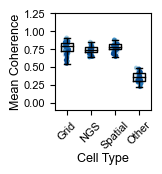

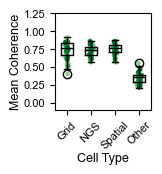

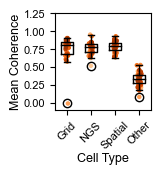

In [100]:
''' Plot Cell Type Coherence within each Age Group (Extended Data Fig. 2B; also was in Reviewer Figure 4)'''

#Young Coherence
fig, ax = plt.subplots(figsize = (1.25,1.25))
coherence = [sgridc[y_sindgrid],sNGSc[y_sind],sspatialc[y_sind],sotherc[y_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(coherence, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=8, rotation = 45)
ax.set_ylabel('Mean Coherence', fontsize=9, labelpad=1)
ax.set_ylim([-0.1,1.25])
ax.set_yticks([0,0.25,0.5,0.75,1,1.25])
ax.tick_params(labelsize = 8)

for i in range(len(coherence)):
    y = coherence[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[0], edgecolors = col_sessiongrid[0], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[0], edgecolors = col_session[0], alpha = 1, s = 5)

fig.savefig(save_folder + 'S2Bleft.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'S2Bleft.svg', dpi=400, bbox_inches='tight')
        
plt.show()

#MA Coherence
fig, ax = plt.subplots(figsize = (1.25,1.25))
coherence = [sgridc[ma_sindgrid],sNGSc[ma_sind],sspatialc[ma_sind],sotherc[ma_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(coherence, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=8, rotation = 45)
ax.set_ylabel('Mean Coherence', fontsize=9, labelpad=1)
ax.set_ylim([-0.1,1.25])
ax.set_yticks([0,0.25,0.5,0.75,1,1.25])
ax.tick_params(labelsize = 8)

for i in range(len(coherence)):
    y = coherence[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[1], edgecolors = col_sessiongrid[1], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[1], edgecolors = col_session[1], alpha = 1, s = 5)

fig.savefig(save_folder + 'S2Bmiddle.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'S2Bmiddle.svg', dpi=400, bbox_inches='tight')

plt.show()

#Aged Coherence
fig, ax = plt.subplots(figsize = (1.25,1.25))
coherence = [sgridc[age_sindgrid],sNGSc[age_sind],sspatialc[age_sind],sotherc[age_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(coherence, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=8, rotation = 45)
ax.set_ylabel('Mean Coherence', fontsize=9, labelpad=1)
ax.set_ylim([-0.1,1.25])
ax.set_yticks([0,0.25,0.5,0.75,1.0,1.25])
ax.tick_params(labelsize = 8)

for i in range(len(coherence)):
    y = coherence[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[2], edgecolors = col_sessiongrid[2], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[2], edgecolors = col_session[2], alpha = 1, s = 5)
        
fig.savefig(save_folder + 'S2Bright.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'S2Bright.svg', dpi=400, bbox_inches='tight')

plt.show()

In [101]:
''' Statistics on Coherence within Age Group, across Cell Types by Session'''

print('Young Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridc[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridc[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSc[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSc[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatialc[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatialc[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherc[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherc[y_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridc[y_sindgrid],sNGSc[y_sind],sspatialc[y_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff)) 
      
print('\nMA Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridc[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridc[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSc[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSc[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatialc[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatialc[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherc[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherc[ma_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridc[ma_sindgrid],sNGSc[ma_sind],sspatialc[ma_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))
      
print('\nAged Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridc[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridc[age_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSc[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSc[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatialc[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatialc[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherc[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherc[age_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridc[age_sindgrid],sNGSc[age_sind],sspatialc[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

Young Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.7743 ± 0.0123 ; 0.7428 ± 0.0071 ; 0.7768 ± 0.0077 ; 0.3571 ± 0.009
H = 11.688081790746423
p = 0.0028971120141539895

MA Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.7383 ± 0.0153 ; 0.731 ± 0.0103 ; 0.7512 ± 0.0102 ; 0.3488 ± 0.0093
H = 2.119846469096431
p = 0.3464824071877076

Aged Coherence, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.7633 ± 0.0198 ; 0.7611 ± 0.0108 ; 0.7842 ± 0.0099 ; 0.3315 ± 0.0119
H = 3.177505033233414
p = 0.20418016428830893


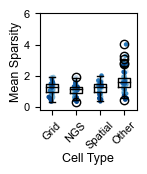

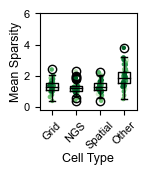

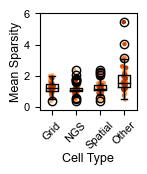

In [102]:
''' Plot Cell Type Sparsity within each Age Group (only in Reviewer Figure 4)'''

#Young Sparsity
fig, ax = plt.subplots(figsize = (1.25,1.25))
Sparsity = [sgrids[y_sindgrid],sNGSs[y_sind],sspatials[y_sind],sothers[y_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Sparsity, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Mean Sparsity', fontsize=9, labelpad=1)
ax.set_ylim([-0.2,6])
ax.set_yticks([0,2,4,6])
ax.tick_params(labelsize = 8)

for i in range(len(Sparsity)):
    y = Sparsity[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[0], edgecolors = col_sessiongrid[0], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[0], edgecolors = col_session[0], alpha = 1, s = 5)

#fig.savefig(save_folder + 'ReviewerFigure4C_1.png', dpi=400, bbox_inches='tight')
#fig.savefig(save_folder + 'ReviewerFigure4C_1.svg', dpi=400, bbox_inches='tight')
plt.show()

#MA Sparsity
fig, ax = plt.subplots(figsize = (1.25,1.25))
Sparsity = [sgrids[ma_sindgrid],sNGSs[ma_sind],sspatials[ma_sind],sothers[ma_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Sparsity, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Mean Sparsity', fontsize=9, labelpad=1)
ax.set_ylim([-0.2,6])
ax.set_yticks([0,2,4,6])
ax.tick_params(labelsize = 8)

for i in range(len(Sparsity)):
    y = Sparsity[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[1], edgecolors = col_sessiongrid[1], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[1], edgecolors = col_session[1], alpha = 1, s = 5)

#fig.savefig(save_folder + 'ReviewerFigure4C_2.png', dpi=400, bbox_inches='tight')
#fig.savefig(save_folder + 'ReviewerFigure4C_2.svg', dpi=400, bbox_inches='tight')
plt.show()

#Aged Sparsity
fig, ax = plt.subplots(figsize = (1.25,1.25))
Sparsity = [sgrids[age_sindgrid],sNGSs[age_sind],sspatials[age_sind],sothers[age_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Sparsity, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Mean Sparsity', fontsize=9, labelpad=1)
ax.set_ylim([-0.2,6])
ax.set_yticks([0,2,4,6])
ax.tick_params(labelsize = 8)

for i in range(len(Sparsity)):
    y = Sparsity[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[2], edgecolors = col_sessiongrid[2], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[2], edgecolors = col_session[2], alpha = 1, s = 5)

#fig.savefig(save_folder + 'ReviewerFigure4C_3.png', dpi=400, bbox_inches='tight')
#fig.savefig(save_folder + 'ReviewerFigure4C_3.svg', dpi=400, bbox_inches='tight')
plt.show()

In [103]:
''' Statistics on Sparsity within Age Group, across Cell Types by Session'''

print('Young Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgrids[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgrids[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSs[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSs[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatials[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatials[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sothers[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sothers[y_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgrids[y_sindgrid],sNGSs[y_sind],sspatials[y_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))
      
print('\nMA Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgrids[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgrids[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSs[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSs[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatials[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatials[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sothers[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sothers[ma_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgrids[ma_sindgrid],sNGSs[ma_sind],sspatials[ma_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))
  
print('\nAged Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgrids[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgrids[age_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSs[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSs[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatials[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatials[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sothers[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sothers[age_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgrids[age_sindgrid],sNGSs[age_sind],sspatials[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

Young Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX
1.1891 ± 0.0551 ; 1.0808 ± 0.046 ; 1.2135 ± 0.0502 ; 1.6464 ± 0.0937
H = 5.664875830251162
p = 0.05886916056784547

MA Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX
1.3264 ± 0.0487 ; 1.1967 ± 0.0436 ; 1.3138 ± 0.0469 ; 1.9246 ± 0.0824
H = 6.3856041146279985
p = 0.04105666647710207

Aged Sparsity, Mean ± SEM: Grid; NGS; Spatial; Other EX
1.2233 ± 0.0478 ; 1.1275 ± 0.0478 ; 1.2404 ± 0.052 ; 1.7559 ± 0.1119
H = 5.998172736762782
p = 0.04983257619325122


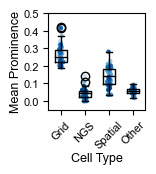

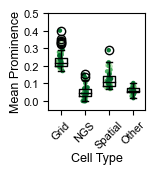

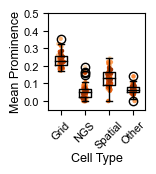

In [104]:
''' Plot Cell Type Distance Tuning within each Age Group (Extended Data Fig. 2C; also was in Reviewer Figure 4)'''

#Young Distance
fig, ax = plt.subplots(figsize = (1.25,1.25))
Distance = [sgridd[y_sindgrid],sNGSd[y_sind],sspatiald[y_sind],sotherd[y_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Distance, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Mean Prominence', fontsize=9, labelpad=1)
ax.set_ylim([-0.05,0.5])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 8)

for i in range(len(Distance)):
    y = Distance[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[0], edgecolors = col_sessiongrid[0], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[0], edgecolors = col_session[0], alpha = 1, s = 5)

fig.savefig(save_folder + 'S2Cleft.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'S2Cleft.svg', dpi=400, bbox_inches='tight')
plt.show()

#MA Distance
fig, ax = plt.subplots(figsize = (1.25,1.25))
Distance = [sgridd[ma_sindgrid],sNGSd[ma_sind],sspatiald[ma_sind],sotherd[ma_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Distance, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Mean Prominence', fontsize=9, labelpad=1)
ax.set_ylim([-0.05,0.5])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 8)

for i in range(len(Distance)):
    y = Distance[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[1], edgecolors = col_sessiongrid[1], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[1], edgecolors = col_session[1], alpha = 1, s = 5)

fig.savefig(save_folder + 'S2Cmiddle.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'S2Cmiddle.svg', dpi=400, bbox_inches='tight')
plt.show()

#Aged Distance
fig, ax = plt.subplots(figsize = (1.25,1.25))
Distance = [sgridd[age_sindgrid],sNGSd[age_sind],sspatiald[age_sind],sotherd[age_sind]]
labels = ['Grid','NGS','Spatial','Other']
w = 0.5

plt.boxplot(Distance, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Cell Type', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9, rotation = 45)
ax.set_ylabel('Mean Prominence', fontsize=9, labelpad=1)
ax.set_ylim([-0.05,0.5])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 8)

for i in range(len(Distance)):
    y = Distance[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    if i == 0:
        plt.scatter(x, y, color = col_sessiongrid[2], edgecolors = col_sessiongrid[2], alpha = 1, s = 5)
    else:
        plt.scatter(x, y, color = col_session[2], edgecolors = col_session[2], alpha = 1, s = 5)

fig.savefig(save_folder + 'S2Cright.png', dpi=400, bbox_inches='tight')
fig.savefig(save_folder + 'S2Cright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [105]:
''' Statistics on Distance Tuning within Age Group, across Cell Types by Session'''

print('Young Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridd[y_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridd[y_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSd[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSd[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatiald[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatiald[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherd[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherd[y_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridd[y_sindgrid],sNGSd[y_sind],sspatiald[y_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff)) 
      
print('\nMA Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridd[ma_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridd[ma_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSd[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSd[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatiald[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatiald[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherd[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherd[ma_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridd[ma_sindgrid],sNGSd[ma_sind],sspatiald[ma_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))
      
print('\nAged Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX')
print(str(np.round(np.mean(sgridd[age_sindgrid]), 4)) + ' ± ' + str(np.round(stats.sem(sgridd[age_sindgrid]), 4)) + ' ; ' 
      + str(np.round(np.mean(sNGSd[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sNGSd[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sspatiald[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sspatiald[age_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sotherd[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sotherd[age_sind]), 4)))
      
stat, p_diff = stats.kruskal(sgridd[age_sindgrid],sNGSd[age_sind],sspatiald[age_sind])
print('H = ' + str(stat))
print('p = ' + str(p_diff))

Young Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.2616 ± 0.0074 ; 0.0407 ± 0.0036 ; 0.1398 ± 0.007 ; 0.0574 ± 0.0023
H = 133.1360266784425
p = 1.229926433712831e-29

MA Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.2322 ± 0.0066 ; 0.0477 ± 0.0044 ; 0.1235 ± 0.0065 ; 0.0607 ± 0.0022
H = 131.9196169932096
p = 2.259535362250074e-29

Aged Distance Tuning, Mean ± SEM: Grid; NGS; Spatial; Other EX
0.2338 ± 0.0054 ; 0.0539 ± 0.0057 ; 0.1332 ± 0.0068 ; 0.0657 ± 0.0032
H = 121.25679413887084
p = 4.671127332652958e-27


In [106]:
''' Post Hoc Comparisons: Young '''

import statsmodels.api as sm
import scikit_posthocs as ph

# Collect all relevant data into pandas dataframe
CellType = list(np.concatenate((np.full(len(sgridc[y_sindgrid]),str('grid')),np.full(len(sNGSc[y_sind]),str('NGS')),np.full(len(sspatialc[y_sind]),str('spatial')),np.full(len(sotherc[y_sind]),str('other')))))
Coherence = list(np.concatenate((sgridc[y_sindgrid],sNGSc[y_sind],sspatialc[y_sind],sotherc[y_sind])))
Sparsity = list(np.concatenate((sgrids[y_sindgrid],sNGSs[y_sind],sspatials[y_sind],sothers[y_sind])))
Distance = list(np.concatenate((sgridd[y_sindgrid],sNGSd[y_sind],sspatiald[y_sind],sotherd[y_sind])))
            
tuples = list(zip(CellType,Coherence,Sparsity,Distance))
tuples

df = pd.DataFrame(tuples, columns = ['CellType','Coherence','Sparsity','Distance'])

#Run Post Hoc Tests on Coherence, Young
ph.posthoc_conover(df, val_col = 'Coherence', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,1.207614e-03,3.934879e-24,2.241555e-03
grid,1.207614e-03,1.000000e+00,4.035684e-35,7.586336e-01
other,3.934879e-24,4.035684e-35,1.000000e+00,1.896503e-34
spatial,2.241555e-03,7.586336e-01,1.896503e-34,1.000000e+00


In [107]:
#Run Post Hoc Tests on Sparsity, Young
ph.posthoc_conover(df, val_col = 'Sparsity', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,0.172174,3.415474e-08,0.088802
grid,1.721738e-01,1.000000,1.188071e-04,0.649194
other,3.415474e-08,0.000119,1.000000e+00,0.000547
spatial,8.880191e-02,0.649194,5.472970e-04,1.000000


In [108]:
#Run Post Hoc Tests on Distance Tuning, Young
ph.posthoc_conover(df, val_col = 'Distance', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,1.261298e-68,2.601774e-06,9.294353e-39
grid,1.261298e-68,1.000000e+00,2.648620e-55,2.777566e-20
other,2.601774e-06,2.648620e-55,1.000000e+00,1.173417e-23
spatial,9.294353e-39,2.777566e-20,1.173417e-23,1.000000e+00


In [109]:
''' Post Hoc Comparisons: MA '''

# Collect all relevant data into pandas dataframe
CellType = list(np.concatenate((np.full(len(sgridc[ma_sindgrid]),str('grid')),np.full(len(sNGSc[ma_sind]),str('NGS')),np.full(len(sspatialc[ma_sind]),str('spatial')),np.full(len(sotherc[ma_sind]),str('other')))))
Coherence = list(np.concatenate((sgridc[ma_sindgrid],sNGSc[ma_sind],sspatialc[ma_sind],sotherc[ma_sind])))
Sparsity = list(np.concatenate((sgrids[ma_sindgrid],sNGSs[ma_sind],sspatials[ma_sind],sothers[ma_sind])))
Distance = list(np.concatenate((sgridd[ma_sindgrid],sNGSd[ma_sind],sspatiald[ma_sind],sotherd[ma_sind])))
            
tuples = list(zip(CellType,Coherence,Sparsity,Distance))
tuples

df = pd.DataFrame(tuples, columns = ['CellType','Coherence','Sparsity','Distance'])

#Run Post Hoc Tests on Coherence, MA
ph.posthoc_conover(df, val_col = 'Coherence', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,4.037986e-01,8.093886e-29,4.037986e-01
grid,4.037986e-01,1.000000e+00,8.935363e-33,8.422554e-01
other,8.093886e-29,8.935363e-33,1.000000e+00,1.471503e-33
spatial,4.037986e-01,8.422554e-01,1.471503e-33,1.000000e+00


In [110]:
#Run Post Hoc Tests on Sparsity, MA
ph.posthoc_conover(df, val_col = 'Sparsity', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,7.742643e-02,9.038266e-15,7.742643e-02
grid,7.742643e-02,1.000000e+00,6.153040e-09,9.236451e-01
other,9.038266e-15,6.153040e-09,1.000000e+00,3.878109e-09
spatial,7.742643e-02,9.236451e-01,3.878109e-09,1.000000e+00


In [111]:
#Run Post Hoc Tests on Distance, MA
ph.posthoc_conover(df, val_col = 'Distance', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,4.335665e-63,9.690143e-04,1.699989e-34
grid,4.335665e-63,1.000000e+00,4.912473e-53,6.147376e-17
other,9.690143e-04,4.912473e-53,1.000000e+00,9.300833e-24
spatial,1.699989e-34,6.147376e-17,9.300833e-24,1.000000e+00


In [112]:
''' Post Hoc Comparisons: Aged '''

# Collect all relevant data into pandas dataframe
CellType = list(np.concatenate((np.full(len(sgridc[age_sindgrid]),str('grid')),np.full(len(sNGSc[age_sind]),str('NGS')),np.full(len(sspatialc[y_sind]),str('spatial')),np.full(len(sotherc[age_sind]),str('other')))))
Coherence = list(np.concatenate((sgridc[age_sindgrid],sNGSc[age_sind],sspatialc[age_sind],sotherc[age_sind])))
Sparsity = list(np.concatenate((sgrids[age_sindgrid],sNGSs[age_sind],sspatials[age_sind],sothers[age_sind])))
Distance = list(np.concatenate((sgridd[age_sindgrid],sNGSd[age_sind],sspatiald[age_sind],sotherd[age_sind])))
            
tuples = list(zip(CellType,Coherence,Sparsity,Distance))
tuples

df = pd.DataFrame(tuples, columns = ['CellType','Coherence','Sparsity','Distance'])

#Run Post Hoc Tests on Coherence, Aged
ph.posthoc_conover(df, val_col = 'Coherence', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,3.353262e-01,1.911447e-23,3.353262e-01
grid,3.353262e-01,1.000000e+00,9.676470e-28,9.349145e-01
other,1.911447e-23,9.676470e-28,1.000000e+00,4.075623e-28
spatial,3.353262e-01,9.349145e-01,4.075623e-28,1.000000e+00


In [113]:
#Run Post Hoc Tests on Sparsity, Aged
ph.posthoc_conover(df, val_col = 'Sparsity', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,0.105026,1.657429e-09,0.119118
grid,1.050265e-01,1.000000,5.692671e-05,0.814016
other,1.657429e-09,0.000057,1.000000e+00,0.000023
spatial,1.191178e-01,0.814016,2.310496e-05,1.000000


In [114]:
#Run Post Hoc Tests on Distance, Aged
ph.posthoc_conover(df, val_col = 'Distance', group_col = 'CellType', p_adjust = 'holm')

,NGS,grid,other,spatial
NGS,1.000000e+00,7.662519e-53,8.215278e-03,8.442877e-25
grid,7.662519e-53,1.000000e+00,7.006450e-45,1.865662e-16
other,8.215278e-03,7.006450e-45,1.000000e+00,7.050003e-17
spatial,8.442877e-25,1.865662e-16,7.050003e-17,1.000000e+00


Please note statistical comparisons of grid vs. spatial or NGS vs. spatial cell groups are invalid given that spatial cells include a mixture of grid and non-grid spatial cells. They're reported above but should not be interpreted.

# Compare cell type spatial tuning to shuffle. Plot Extended Data Fig. 2D.

In [30]:
''' For grid & ngs cells, save shuffle distributions of sparsity & coherence scores. '''

gridsparsity = []
gridshuffsparsity = []
gridcoherence = []
gridshuffcoherence = []
ngssparsity = []
ngsshuffsparsity = []
ngscoherence = []
ngsshuffcoherence = []

P99coherence = []
P99sparsity = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 

        #get cell IDs, filtered behavioral/spike data, & relevant score
        gridcell = d['gridcell'].astype(bool)
        ngscell = d['ngscell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscells = cell_IDs[ngscell]
        
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            
            P99s = np.percentile(np.ravel(shuffsparsityascores[:,sdx]), 99)
            P99c = np.percentile(np.ravel(shuffspatialacoherencescores[:,sdx]), 99)
            P99coherence = np.append(P99coherence, P99c)
            P99sparsity = np.append(P99sparsity, P99s)
        
        for i, c in enumerate(gridcells):
            sdx = np.where(cell_IDs == c)[0][0]
        
            shuffsparsity = np.random.choice(np.ravel(shuffsparsityascores[:,sdx]))
            shuffcoherence = np.random.choice(np.ravel(shuffspatialacoherencescores[:,sdx]))
            coherence = spatialacoherence_scores[sdx]
            sparsity = sparsitya_scores[sdx]
            
            gridsparsity = np.append(gridsparsity,sparsity)
            gridshuffsparsity = np.append(gridshuffsparsity,shuffsparsity)
            gridcoherence = np.append(gridcoherence,coherence)
            gridshuffcoherence = np.append(gridshuffcoherence,shuffcoherence)
            
        for i, c in enumerate(ngscells):
            sdx = np.where(cell_IDs == c)[0][0]
            
            shuffsparsity = np.random.choice(np.ravel(shuffsparsityascores[:,sdx]))
            shuffcoherence = np.random.choice(np.ravel(shuffspatialacoherencescores[:,sdx]))
            coherence = spatialacoherence_scores[sdx]
            sparsity = sparsitya_scores[sdx]

            ngssparsity = np.append(ngssparsity,sparsity)
            ngsshuffsparsity = np.append(ngsshuffsparsity,shuffsparsity)
            ngscoherence = np.append(ngscoherence,coherence)
            ngsshuffcoherence = np.append(ngsshuffcoherence,shuffcoherence)

print('n total cells: ' + str(len(P99coherence)))
print('n total grid, ngs cells: ' + str(len(gridsparsity)) + ', ' + str(len(ngssparsity)))
print('mean ± SEM coherence shuffle P99: ' + str(np.nanmean(P99coherence)) + ', ' + str(stats.sem(P99coherence, nan_policy = 'omit')))
print('mean ± SEM sparsity shuffle P99: ' + str(np.nanmean(P99sparsity)) + ', ' + str(stats.sem(P99sparsity, nan_policy = 'omit')))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

n total cells: 43388
n total grid, ngs cells: 6508, 6559
mean ± SEM coherence shuffle P99: 0.47053095825735286, 0.000873163996737665
mean ± SEM sparsity shuffle P99: 1.3739416484587894, 0.011832635763318637


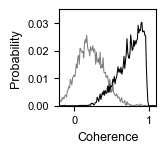

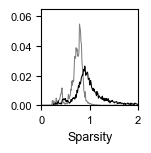


Coherence, NGS vs. Shuff:
Mean, SEM NGS:
0.7419239788222454 0.002050831898278205
Mean, SEM Shuffle:
0.21487383367722784 0.002272495901125764
stat = 201.0
p_cells = 0.0

Sparsity, NGS vs. Shuff:
Mean, SEM NGS:
1.1021215614414288 0.009112407391108976
Mean, SEM Shuffle:
0.724056308363315 0.001833968137546515
stat = 185.0
p_cells = 0.0


In [31]:
''' Plot Coherence & Sparsity Score Distributions vs. Shuffle for NGS Cells (Extended Data Fig. 2D) '''
bins = np.arange(-0.2,1.1,0.01)
bcoherence, bin_edges = np.histogram(ngscoherence, bins = bins)
pdf = bcoherence / sum(bcoherence)
shuffcoherence, shuffbin_edges = np.histogram(ngsshuffcoherence, bins = bins)
shuffpdf = shuffcoherence / sum(shuffcoherence)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Coherence', fontsize = 9)
ax.set_xlim([-0.2,1.1])
ax.set_ylim([0,0.035])
ax.set_yticks([0,0.01,0.02,0.03])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'S2Dleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2Dleft.svg', dpi=400, bbox_inches='tight')
plt.show()

bins = np.arange(0,2,0.01)
bsparsity, bin_edges = np.histogram(ngssparsity, bins = bins)
pdf = bsparsity / sum(bsparsity)

shuffbsparsity, shuffbin_edges = np.histogram(ngsshuffsparsity, bins = bins)
shuffpdf = shuffbsparsity / sum(shuffbsparsity)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_xlabel('Sparsity', fontsize = 9)
ax.set_xlim([0,2])
ax.set_ylim([0,0.065])
ax.set_yticks([0,0.02,0.04,0.06])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'S2Dright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2Dright.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
print('\nCoherence, NGS vs. Shuff:')
print('Mean, SEM NGS:')
print(np.nanmean(ngscoherence), stats.sem(ngscoherence, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(ngsshuffcoherence), stats.sem(ngsshuffcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(ngscoherence[~np.isnan(ngsshuffcoherence)], ngsshuffcoherence[~np.isnan(ngsshuffcoherence)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

print('\nSparsity, NGS vs. Shuff:')
print('Mean, SEM NGS:')
print(np.nanmean(ngssparsity), stats.sem(ngssparsity, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(ngsshuffsparsity), stats.sem(ngsshuffsparsity, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(ngssparsity[~np.isnan(ngsshuffsparsity)], ngsshuffsparsity[~np.isnan(ngsshuffsparsity)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

In [35]:
#Print Source Data for Extended Data Fig. 2d 
#print(list(ngscoherence))
#print(list(ngsshuffcoherence))
#print(list(ngssparsity))
#print(list(ngsshuffsparsity))

[0.9004359115030866, 0.9107342044112461, 1.0418714206253976, 0.9284291629369273, 0.9035838240264613, 0.9047729147988111, 0.9082786898425634, 0.9496266611934067, 0.9031060691474976, 0.9201361740163656, 0.9078405776842957, 0.907447472089307, 0.9318184834570256, 0.9288059796202518, 0.9029300845538314, 0.9360870675749859, 0.9083749034250642, 0.9106253073537601, 0.908713639777622, 0.9021733170776375, 0.9033468593233581, 0.899169771728795, 0.9018739836050669, 0.9015908600239803, 0.9044507548519984, 1.0317934346812818, 0.9869621381822362, 0.9058852236448702, 0.9319701921142292, 0.926589479701687, 0.8988350125229058, 0.8999974929891881, 0.9109556005982867, 0.9045370104373932, 0.9313759238339748, 0.9025214611445107, 0.9048224090786671, 0.9008403399396049, 0.9041574373962052, 0.9400098536904921, 0.9296016558979481, 0.9017633686407622, 0.9192805847415039, 0.9479543440525534, 0.9013283719252926, 0.9032643964269412, 0.9062337417714103, 0.9062243631544391, 0.9046290054542865, 0.900410916204934, 0.91

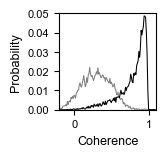

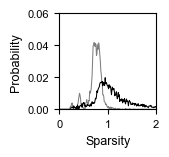

Coherence, Grid vs. Shuff:
Mean, SEM Grid:
0.7827693906051894 0.0023869616308690575
Mean, SEM Shuffle:
0.2951813800811123 0.0024540574993663347
stat = 36539.0
p_cells = 0.0

Sparsity, Grid vs. Shuff:
Mean, SEM Grid:
1.2257912236952178 0.009208855518210901
Mean, SEM Shuffle:
0.7423834254238416 0.0020302036566471437
stat = 145028.0
p_cells = 0.0


In [117]:
''' Plot Coherence & Sparsity Score Distributions vs. Shuffle for Grid Cells '''

bins = np.arange(-0.2,1.1,0.01)
coherence, bin_edges = np.histogram(gridcoherence, bins = bins)
pdf = coherence / sum(coherence)

shuffcoherence, shuffbin_edges = np.histogram(gridshuffcoherence, bins = bins)
shuffpdf = shuffcoherence / sum(shuffcoherence)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Coherence', fontsize = 9)
ax.set_xlim([-0.2,1.1])
ax.set_ylim([0,0.05])
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax.tick_params(labelsize = 8)
#plt.savefig(save_folder + 'gridcoherence.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'gridcoherence.svg', dpi=400, bbox_inches='tight')
plt.show()

bins = np.arange(0,2,0.01)
sparsity, bin_edges = np.histogram(gridsparsity, bins = bins)
pdf = sparsity / sum(sparsity)

shuffsparsity, shuffbin_edges = np.histogram(gridshuffsparsity, bins = bins)
shuffpdf = shuffsparsity / sum(shuffsparsity)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Sparsity', fontsize = 9)
ax.set_xlim([0,2])
ax.set_ylim([0,0.06])
ax.set_yticks([0,0.02,0.04,0.06])
ax.tick_params(labelsize = 8)
#plt.savefig(save_folder + 'gridsparsity.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'gridsparsity.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
print('Coherence, Grid vs. Shuff:')
print('Mean, SEM Grid:')
print(np.nanmean(gridcoherence), stats.sem(gridcoherence, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(gridshuffcoherence), stats.sem(gridshuffcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(gridcoherence, gridshuffcoherence)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

print('\nSparsity, Grid vs. Shuff:')
print('Mean, SEM Grid:')
print(np.nanmean(gridsparsity), stats.sem(gridsparsity, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(gridshuffsparsity), stats.sem(gridshuffsparsity, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(gridsparsity, gridshuffsparsity)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

In [118]:
''' For spatial cells, save shuffle distributions of sparsity & coherence scores. '''

spatialsparsity = []
spatialshuffsparsity = []
spatialcoherence = []
spatialshuffcoherence = []

P99coherence = []
P99sparsity = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 

        #get cell IDs, filtered behavioral/spike data, & relevant score
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            
            P99s = np.percentile(np.ravel(shuffsparsityascores[:,sdx]), 99)
            P99c = np.percentile(np.ravel(shuffspatialacoherencescores[:,sdx]), 99)
            P99coherence = np.append(P99coherence, P99c)
            P99sparsity = np.append(P99sparsity, P99s)
        
        for i, c in enumerate(spatialcells):
            sdx = np.where(cell_IDs == c)[0][0]
        
            shuffsparsity = np.random.choice(np.ravel(shuffsparsityascores[:,sdx]))
            shuffcoherence = np.random.choice(np.ravel(shuffspatialacoherencescores[:,sdx]))
            coherence = spatialacoherence_scores[sdx]
            sparsity = sparsitya_scores[sdx]
            
            spatialsparsity = np.append(spatialsparsity,sparsity)
            spatialshuffsparsity = np.append(spatialshuffsparsity,shuffsparsity)
            spatialcoherence = np.append(spatialcoherence,coherence)
            spatialshuffcoherence = np.append(spatialshuffcoherence,shuffcoherence)

print('n total cells: ' + str(len(P99coherence)))
print('n total spatial cells: ' + str(len(spatialsparsity)))
print('mean ± SEM coherence shuffle P99: ' + str(np.nanmean(P99coherence)) + ', ' + str(stats.sem(P99coherence, nan_policy = 'omit')))
print('mean ± SEM sparsity shuffle P99: ' + str(np.nanmean(P99sparsity)) + ', ' + str(stats.sem(P99sparsity, nan_policy = 'omit')))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

n total cells: 43388
n total spatial cells: 13464
mean ± SEM coherence shuffle P99: 0.47053095825735286, 0.000873163996737665
mean ± SEM sparsity shuffle P99: 1.3739416484587894, 0.011832635763318637


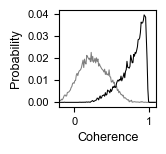

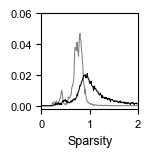


Coherence, Spatial vs. Shuff:
Mean, SEM spatial:
0.7785060066564314 0.0013952809876167662
Mean, SEM Shuffle:
0.25522734158626265 0.0016592780567066298
stat = 248.0
p_cells = 0.0

Sparsity, Spatial vs. Shuff:
Mean, SEM spatial:
1.2348096391421857 0.007944757910117235
Mean, SEM Shuffle:
0.736508844946469 0.001733809239421338
stat = 32046.0
p_cells = 0.0


In [123]:
''' Plot Coherence & Sparsity Score Distributions vs. Shuffle for Spatial Cells '''
bins = np.arange(-0.2,1.1,0.01)
bcoherence, bin_edges = np.histogram(spatialcoherence, bins = bins)
pdf = bcoherence / sum(bcoherence)
shuffcoherence, shuffbin_edges = np.histogram(spatialshuffcoherence, bins = bins)
shuffpdf = shuffcoherence / sum(shuffcoherence)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Coherence', fontsize = 9)
ax.set_xlim([-0.2,1.1])
ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.tick_params(labelsize = 8)
plt.show()


bins = np.arange(0,2,0.01)
bsparsity, bin_edges = np.histogram(spatialsparsity, bins = bins)
pdf = bsparsity / sum(bsparsity)

shuffbsparsity, shuffbin_edges = np.histogram(spatialshuffsparsity, bins = bins)
shuffpdf = shuffbsparsity / sum(shuffbsparsity)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_xlabel('Sparsity', fontsize = 9)
ax.set_xlim([0,2])
ax.set_yticks([0,0.02,0.04,0.06])
ax.tick_params(labelsize = 8)
plt.show()

#STATS
print('\nCoherence, Spatial vs. Shuff:')
print('Mean, SEM spatial:')
print(np.nanmean(spatialcoherence), stats.sem(spatialcoherence, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(spatialshuffcoherence), stats.sem(spatialshuffcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(spatialcoherence[~np.isnan(spatialshuffcoherence)], spatialshuffcoherence[~np.isnan(spatialshuffcoherence)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#STATS
print('\nSparsity, Spatial vs. Shuff:')
print('Mean, SEM spatial:')
print(np.nanmean(spatialsparsity), stats.sem(spatialsparsity, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(spatialshuffsparsity), stats.sem(spatialshuffsparsity, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(spatialsparsity[~np.isnan(spatialshuffsparsity)], spatialshuffsparsity[~np.isnan(spatialshuffsparsity)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

# Compare grid vs. non-grid spatial cell response to gain manipulation. Plot Extended Data Fig. 2F.

In [36]:
''' Compare Grid vs. NGS Cell Response to Gain Change by Age Group'''
dt = 0.02
b = 2

#age group arrays
crossAgrida = []
crossAgridma = []
crossAgridy = []
crossAngsa = []
crossAngsma = []
crossAngsy = []
crossBgrida = []
crossBgridma = []
crossBgridy = []
crossBngsa = []
crossBngsma = []
crossBngsy = []

for m, session in zip(mice,sessions):
    
    m_crossAgrid = []
    m_crossAngs = []
    m_crossBgrid = []
    m_crossBngs = []

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        
        # maps including equal numbers normal & gain-adjusted trials removing skipped trials
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        gain = trialinfo['gain']
        
        #check if mouse reached gain period; if not append NaN to all arrays & continue 
        if len(gain) < 200:
            #print(str(m) + str(s) + ' did not reach gain change')
            continue 
            
        # get alt A' and B' trials
        A_trials = np.where((left == 1))[0]
        A_trials = list(A_trials[A_trials >= 140])
        B_trials = np.where((left == 0))[0]
        B_trials = list(B_trials[B_trials >= 140])
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
            
        alltrial = np.arange(0,220,1)
            
        #remove any skipped trials from A' and B'    
        for n, t in enumerate(skippedtrials):
            if t in A_trials:
                A_trials.remove(t)
            elif t in B_trials:
                B_trials.remove(t)
    
        #get count of gain in each context & select equal number of last Context A or B alt trials before gain
        gain_trials = np.where((gain == 0.7))[0]
        gain_trials = list(gain_trials)
        nagain = len(np.intersect1d(np.asarray(A_trials), np.asarray(gain_trials)))
        nbgain = len(np.intersect1d(np.asarray(B_trials), np.asarray(gain_trials)))
        
        Agtrials = []
        A_trials = np.asarray(A_trials)
        for n in range(0, nagain):
            Agtrials = np.append(Agtrials, A_trials[A_trials < 200][-(n+1)])
        Agtrials = np.append(Agtrials, np.intersect1d(A_trials, np.asarray(gain_trials)))
        Agtrials = list(np.sort(Agtrials.astype(int)))  
             
        nbgain = len(np.intersect1d(np.asarray(B_trials), np.asarray(gain_trials)))
        Bgtrials = []
        B_trials = np.asarray(B_trials)
        for n in range(0, nbgain):
            Bgtrials = np.append(Bgtrials, B_trials[B_trials < 200][-(n+1)])
        Bgtrials = np.append(Bgtrials, np.intersect1d(B_trials, np.asarray(gain_trials)))                   
        Bgtrials = list(np.sort(Bgtrials.astype(int)))
    
        #get indices of observations corresponding to the selected trials
        Agidx = []
        for t in Agtrials:
            Agidx = np.append(Agidx, np.where(trial == t)[0])
        Agidx = Agidx.astype(int)
            
        Bgidx = []
        for t in Bgtrials:
            Bgidx = np.append(Bgidx, np.where(trial == t)[0])
        Bgidx = Bgidx.astype(int)
        
        #Get A (normal & gain alt) & B (normal & gain alt) spatial maps
        #handle edge cases where there aren't any gain change trials in one map or another
        if len(Bgidx) == 0:
            print(str(m) + str(s) + ' no B gain change trials')
            gainAFR, _, _ = ps.tuning_curve_bytrial(posx[Agidx], trial[Agidx], Y[Agidx,:], dt, sigma = 2, b=2, smooth=True, normalize=False, occupancy=True)
            
            #get difference in avg. pairwise cross_trial_correlation btwn baseline & gain change trials for each context
            deltA = []
            deltB = []
            for i, c in enumerate(cell_IDs):
                sdx = (np.where(cell_IDs == c)[0][0]).astype(int)

                #ContextA
                sim, _  = ps.cross_trial_correlation(gainAFR[:,:,sdx], shift = False) 
                baseline_sim = pd.DataFrame(sim[:nagain,:nagain])
                baseline_avg = ((baseline_sim.sum().sum() - nagain) / 2) / ((nagain**2 - nagain)/2)
                gain_sim = pd.DataFrame(sim[nagain:,:nagain])
                gain_avg = ((gain_sim.sum().sum() - nagain) / 2) / ((nagain**2 - nagain)/2)
                deltA = np.append(deltA, (baseline_avg - gain_avg))

            #pool by age group
            if m in SM_aged_mice:
                crossAgrida = np.append(crossAgrida, deltA[gridcell])
                crossAngsa = np.append(crossAngsa, deltA[ngscell])
                crossBgrida = np.append(crossBgrida, np.nan)
                crossBngsa = np.append(crossBngsa, np.nan)
            elif m in SM_MA_mice:
                crossAgridma = np.append(crossAgridma, deltA[gridcell])
                crossAngsma = np.append(crossAngsma, deltA[ngscell])
                crossBgridma = np.append(crossBgridma, np.nan)
                crossBngsma = np.append(crossBngsma, np.nan)
            else:
                crossAgridy = np.append(crossAgridy, deltA[gridcell])
                crossAngsy = np.append(crossAngsy, deltA[ngscell])
                crossBgridy = np.append(crossBgridy, np.nan)
                crossBngsy = np.append(crossBngsy, np.nan)
        
        elif len(Agidx) == 0:
            print(str(m) + str(s) + ' no A gain change trials')
            gainBFR, _, _ = ps.tuning_curve_bytrial(posx[Bgidx], trial[Bgidx], Y[Bgidx,:], dt, sigma = 2, b=2, smooth=True, normalize=False, occupancy=True)
        
            #get difference in avg. pairwise cross_trial_correlation btwn baseline & gain change trials for each context
            deltA = []
            deltB = []
            for i, c in enumerate(spatialcells):
                sdx = (np.where(cell_IDs == c)[0][0]).astype(int)

                #ContextB
                sim, _ = ps.cross_trial_correlation(gainBFR[:,:,sdx], shift = False) 
                baseline_sim = pd.DataFrame(sim[:nbgain,:nbgain])
                baseline_avg = ((baseline_sim.sum().sum() - nbgain) / 2) / ((nbgain**2 - nbgain)/2)
                gain_sim = pd.DataFrame(sim[nbgain:,:nbgain])
                gain_avg = ((gain_sim.sum().sum() - nbgain) / 2) / ((nbgain**2 - nbgain)/2)
                deltB = np.append(deltB, (baseline_avg - gain_avg))
                
            #pool by age group
            if m in SM_aged_mice:
                crossAgrida = np.append(crossAgrida, np.nan)
                crossAngsa = np.append(crossAngsa, np.nan)
                crossBgrida = np.append(crossBgrida, deltB[gridcell])
                crossBngsa = np.append(crossBngsa, deltB[ngscell])
            elif m in SM_MA_mice:
                crossAgridma = np.append(crossAgridma, np.nan)
                crossAngsma = np.append(crossAngsma, np.nan)
                crossBgridma = np.append(crossBgridma, deltB[gridcell])
                crossBngsma = np.append(crossBngsma, deltB[ngscell])
            else:
                crossAgridy = np.append(crossAgridy, np.nan)
                crossAngsy = np.append(crossAngsy, np.nan)
                crossBgridy = np.append(crossBgridy, deltB[gridcell])
                crossBngsy = np.append(crossBngsy, deltB[ngscell])
                
        else:
            gainAFR, _, _ = ps.tuning_curve_bytrial(posx[Agidx], trial[Agidx], Y[Agidx,:], dt, sigma = 2, b=2, smooth=True, normalize=False, occupancy=True)
            gainBFR, _, _ = ps.tuning_curve_bytrial(posx[Bgidx], trial[Bgidx], Y[Bgidx,:], dt, sigma = 2, b=2, smooth=True, normalize=False, occupancy=True)
             
            #get difference in avg. pairwise cross_trial_correlation btwn baseline & gain change trials for each context
            deltA = []
            deltB = []
            for i, c in enumerate(cell_IDs):
                sdx = (np.where(cell_IDs == c)[0][0]).astype(int)

                #ContextA
                sim, _  = ps.cross_trial_correlation(gainAFR[:,:,sdx], shift = False) 
                baseline_sim = pd.DataFrame(sim[:nagain,:nagain]) #non-gain vs. non-gain
                baseline_avg = ((baseline_sim.sum().sum() - nagain) / 2) / ((nagain**2 - nagain)/2)
                gain_sim = pd.DataFrame(sim[nagain:,:nagain]) #gain vs. non-gain
                gain_avg = ((gain_sim.sum().sum() - nagain) / 2) / ((nagain**2 - nagain)/2)
                deltA = np.append(deltA, (baseline_avg - gain_avg))

                #ContextB
                sim, _ = ps.cross_trial_correlation(gainBFR[:,:,sdx], shift = False) 
                baseline_sim = pd.DataFrame(sim[:nbgain,:nbgain])
                baseline_avg = ((baseline_sim.sum().sum() - nbgain) / 2) / ((nbgain**2 - nbgain)/2)
                gain_sim = pd.DataFrame(sim[nbgain:,:nbgain])
                gain_avg = ((gain_sim.sum().sum() - nbgain) / 2) / ((nbgain**2 - nbgain)/2)
                deltB = np.append(deltB, (baseline_avg - gain_avg))

            #pool by age group
            if m in SM_aged_mice:
                crossAgrida = np.append(crossAgrida, deltA[gridcell])
                crossAngsa = np.append(crossAngsa, deltA[ngscell])
                crossBgrida = np.append(crossBgrida, deltB[gridcell])
                crossBngsa = np.append(crossBngsa, deltB[ngscell])
            elif m in SM_MA_mice:
                crossAgridma = np.append(crossAgridma, deltA[gridcell])
                crossAngsma = np.append(crossAngsma, deltA[ngscell])
                crossBgridma = np.append(crossBgridma, deltB[gridcell])
                crossBngsma = np.append(crossBngsma, deltB[ngscell])
            else:
                crossAgridy = np.append(crossAgridy, deltA[gridcell])
                crossAngsy = np.append(crossAngsy, deltA[ngscell])
                crossBgridy = np.append(crossBgridy, deltB[gridcell])
                crossBngsy = np.append(crossBngsy, deltB[ngscell])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Y22092922_record5 no B gain change trials


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

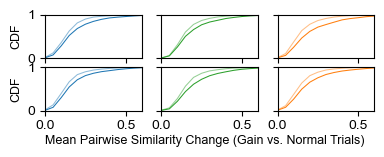

In [37]:
''' Plot Gain Change Response CDF by Age Group (Extended Data Fig. 3h)'''

bins = np.arange(-0.2,0.8,0.05)
fig, ax = plt.subplots(2,3, figsize = (4.25, 1.25), sharey = True, sharex = True)
#fig.suptitle('Avg. Pairwise Cross Correlation Change', fontsize = 10)

# Young A Grid vs. ngs
y, bin_edges = np.histogram(crossAgridy, bins = bins)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax[0,0].plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', label = 'grid')

y, bin_edges = np.histogram(crossAngsy, bins = bins)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax[0,0].plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', alpha = 0.5, label = 'ngs')
ax[0,0].set_ylabel('CDF', fontsize = 9)
#ax[0,0].legend(fontsize = 9)

# MA A Grid vs. ngs
ma, bin_edges = np.histogram(crossAgridma, bins = bins)
pdf = ma / sum(ma)
macdf = np.cumsum(pdf)
ax[0,1].plot(bin_edges[1:], macdf, '-', linewidth = 0.75, color = 'C2', label = 'grid')

ma, bin_edges = np.histogram(crossAngsma, bins = bins)
pdf = ma / sum(ma)
macdf = np.cumsum(pdf)
ax[0,1].plot(bin_edges[1:], macdf, '-', linewidth = 0.75, color = 'C2', label = 'ngs', alpha = 0.5)

# Aged A Grid vs. ngs
a, bin_edges = np.histogram(crossAgrida, bins = bins)
pdf = a / sum(a)
acdf = np.cumsum(pdf)
ax[0,2].plot(bin_edges[1:], acdf, '-', linewidth = 0.75, color = 'C1', label = 'grid')

a, bin_edges = np.histogram(crossAngsa, bins = bins)
pdf = a / sum(a)
acdf = np.cumsum(pdf)
ax[0,2].plot(bin_edges[1:], acdf, '-', linewidth = 0.75, color = 'C1', label = 'ngs', alpha = 0.5)

# Young B Grid vs. ngs
y, bin_edges = np.histogram(crossBgridy, bins = bins)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax[1,0].plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', label = 'grid')

y, bin_edges = np.histogram(crossBngsy, bins = bins)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax[1,0].plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', alpha = 0.5, label = 'ngs')
ax[1,0].set_ylabel('CDF', fontsize = 9)
#ax[1,0].legend(fontsize = 9)

# MA B Grid vs. ngs
ma, bin_edges = np.histogram(crossBgridma, bins = bins)
pdf = ma / sum(ma)
macdf = np.cumsum(pdf)
ax[1,1].plot(bin_edges[1:], macdf, '-', linewidth = 0.75, color = 'C2', label = 'grid')

ma, bin_edges = np.histogram(crossBngsma, bins = bins)
pdf = ma / sum(ma)
macdf = np.cumsum(pdf)
ax[1,1].plot(bin_edges[1:], macdf, '-', linewidth = 0.75, color = 'C2', label = 'ngs', alpha = 0.5)
#ax[1,0].legend(fontsize = 9)

# Aged B Grid vs. ngs
a, bin_edges = np.histogram(crossBgrida, bins = bins)
pdf = a / sum(a)
acdf = np.cumsum(pdf)
ax[1,2].plot(bin_edges[1:], acdf, '-', linewidth = 0.75, color = 'C1', label = 'grid')

a, bin_edges = np.histogram(crossBngsa, bins = bins)
pdf = a / sum(a)
acdf = np.cumsum(pdf)
ax[1,2].plot(bin_edges[1:], acdf, '-', linewidth = 0.75, color = 'C1', label = 'ngs', alpha = 0.5)

fig.supxlabel('Mean Pairwise Similarity Change (Gain vs. Normal Trials)', fontsize = 9, y = -0.18)
ax[0,0].set_xlim([0,0.6])
ax[0,0].set_ylim([0,1])

plt.savefig(save_folder + 'S2F.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2F.svg', dpi=400, bbox_inches='tight')
plt.show()

In [38]:
'''Wilcoxon Rank Sums Comparison of Grid vs. NGS Cell Gain Change Response (by Age Group x Context)'''
print('\nYoung A Grid vs. ngs:')
print('crossAyoung_grid ± SEM, crossAyoung_ngs ± SEM')
print(str(np.round(np.nanmean(crossAgridy[~np.isnan(crossAgridy)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAgridy[~np.isnan(crossAgridy)]), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossAngsy[~np.isnan(crossAngsy)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAngsy[~np.isnan(crossAngsy)]), 3)))

stat, p_diff = stats.ranksums(crossAgridy[~np.isnan(crossAgridy)],crossAngsy[~np.isnan(crossAngsy)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nYoung B Grid vs. ngs:')
print('crossByoung_grid ± SEM, crossByoung_ngs ± SEM')
print(str(np.round(np.nanmean(crossBgridy[~np.isnan(crossBgridy)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBgridy[~np.isnan(crossBgridy)], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossBngsy[~np.isnan(crossBngsy)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBngsy[~np.isnan(crossBngsy)], nan_policy = 'omit'), 3)))

stat, p_diff = stats.ranksums(crossBgridy[~np.isnan(crossBgridy)],crossBngsy[~np.isnan(crossBngsy)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nMA A Grid vs. ngs:')
print('crossAMA_grid ± SEM, crossAMA_ngs ± SEM')
print(str(np.round(np.nanmean(crossAgridma[~np.isnan(crossAgridma)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAgridma[~np.isnan(crossAgridma)]), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossAngsma[~np.isnan(crossAngsma)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAngsma[~np.isnan(crossAngsma)]), 3)))

stat, p_diff = stats.ranksums(crossAgridma[~np.isnan(crossAgridma)],crossAngsma[~np.isnan(crossAngsma)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nMA B Grid vs. ngs:')
print('crossBMA_grid ± SEM, crossBMA_ngs ± SEM')
print(str(np.round(np.nanmean(crossBgridma[~np.isnan(crossBgridma)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBgridma[~np.isnan(crossBgridma)], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossBngsma[~np.isnan(crossBngsma)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBngsma[~np.isnan(crossBngsma)], nan_policy = 'omit'), 3)))

stat, p_diff = stats.ranksums(crossBgridma[~np.isnan(crossBgridma)],crossBngsma[~np.isnan(crossBngsma)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nAged A Grid vs. ngs:')
print('crossAAged_grid ± SEM, crossAAged_ngs ± SEM')
print(str(np.round(np.nanmean(crossAgrida[~np.isnan(crossAgrida)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAgrida[~np.isnan(crossAgrida)]), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossAngsa[~np.isnan(crossAngsa)]), 3)) + ' ± ' + str(np.round(stats.sem(crossAngsa[~np.isnan(crossAngsa)]), 3)))

stat, p_diff = stats.ranksums(crossAgrida[~np.isnan(crossAgrida)],crossAngsa[~np.isnan(crossAngsa)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

print('\nAged B Grid vs. ngs:')
print('crossBAged_grid ± SEM, crossBAged_ngs ± SEM')
print(str(np.round(np.nanmean(crossBgrida[~np.isnan(crossBgrida)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBgrida[~np.isnan(crossBgrida)], nan_policy = 'omit'), 3)) + ' ; ' 
      + str(np.round(np.nanmean(crossBngsa[~np.isnan(crossBngsa)]), 3)) + ' ± ' + str(np.round(stats.sem(crossBngsa[~np.isnan(crossBngsa)], nan_policy = 'omit'), 3)))

stat, p_diff = stats.ranksums(crossBgrida[~np.isnan(crossBgrida)],crossBngsa[~np.isnan(crossBngsa)])
print('stat = ' + str(stat))
print('p_session, P = ' + str(p_diff))

#Print Young Source Data for Extended Data Fig. 2f
#print(list(crossAgridy))
#print(list(crossAngsy))
#print(list(crossBgridy))
#print(list(crossBngsy))

#Print MA Source Data for Extended Data Fig. 2f
#print(list(crossAgridma))
#print(list(crossAngsma))
#print(list(crossBgridma))
#print(list(crossBngsma))

#Print Aged Source Data for Extended Data Fig. 2f
#print(list(crossAgrida))
#print(list(crossAngsa))
#print(list(crossBgrida))
#print(list(crossBngsa))


Young A Grid vs. ngs:
crossAyoung_grid ± SEM, crossAyoung_ngs ± SEM
0.194 ± 0.003 ; 0.144 ± 0.002
stat = 10.32908575823185
p_session, P = 5.205433843513019e-25

Young B Grid vs. ngs:
crossByoung_grid ± SEM, crossByoung_ngs ± SEM
0.188 ± 0.003 ; 0.141 ± 0.002
stat = 10.426019150111031
p_session, P = 1.8862615860032924e-25

MA A Grid vs. ngs:
crossAMA_grid ± SEM, crossAMA_ngs ± SEM
0.195 ± 0.003 ; 0.159 ± 0.002
stat = 7.721288771775169
p_session, P = 1.1515931953677169e-14

MA B Grid vs. ngs:
crossBMA_grid ± SEM, crossBMA_ngs ± SEM
0.209 ± 0.003 ; 0.163 ± 0.002
stat = 10.5627507171043
p_session, P = 4.4347250232300257e-26

Aged A Grid vs. ngs:
crossAAged_grid ± SEM, crossAAged_ngs ± SEM
0.217 ± 0.004 ; 0.15 ± 0.002
stat = 13.089653036302872
p_session, P = 3.773274969511856e-39

Aged B Grid vs. ngs:
crossBAged_grid ± SEM, crossBAged_ngs ± SEM
0.198 ± 0.003 ; 0.143 ± 0.002
stat = 11.594402511167353
p_session, P = 4.399249704484284e-31


# Compare grid vs. non-grid spatial cell rate & global remapping strength (Block A vs. Block B Trials) across age groups. Plot Extended Data Figs. 2G-J. 

In [39]:
''' Across Block A vs. B Trials, in each session, find the fold change in FR and spatial similarity for each grid cell.  '''

ypct_dFR_grid = []
yall_angles_grid = []

mapct_dFR_grid = []
maall_angles_grid = []

agedpct_dFR_grid = []
agedall_angles_grid = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
    
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'       
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        posx = behaviorfil[:,0]
        
        if len(gridcells) > 0:
            cellidx = []
            for i, c in enumerate(gridcells):
                cdx = np.where(cell_IDs == c)[0][0]
                cellidx = np.append(cellidx, cdx)

            #get trial-averaged grid FR by context during block phase
            map0idx = d['Aidx'].astype(int)
            map1idx = d['Bidx'].astype(int)
            FR_0,_,_ = ps.tuning_curve(posx[map0idx], Y[map0idx,:], dt = 0.02, b = 2, smooth=True, l=2, SEM=False, occupancy=True)
            FR_1,_,_ = ps.tuning_curve(posx[map1idx], Y[map1idx,:], dt = 0.02, b = 2, smooth=True, l=2, SEM=False, occupancy=True)
            FR_0 = FR_0[:,cellidx.astype(int)]
            FR_1 = FR_1[:,cellidx.astype(int)]

            #get abs % diff in peak FR for each grid cell
            peak_FR_1 = np.max(FR_1, axis=0)
            peak_FR_0 = np.max(FR_0, axis=0)
            dFR = (np.abs(peak_FR_1 - peak_FR_0) / ((peak_FR_1 + peak_FR_0)/2))*100

            # get angle between maps (spatial similarity score) for each grid cell
            norms_0 = np.linalg.norm(FR_0, axis=0)
            norms_1 = np.linalg.norm(FR_1, axis=0)
            angle = np.zeros(FR_0.shape[1])
            for i, n0 in enumerate(norms_0):
                n1 = norms_1[i]
                normalized_FR_0 = FR_0[:, i]/n0
                normalized_FR_1 = FR_1[:, i]/n1   
                angle[i] = normalized_FR_0 @ normalized_FR_1

            #save results for each age group
            if m in SM_aged_mice:
                agedpct_dFR_grid = np.append(agedpct_dFR_grid, dFR)
                agedall_angles_grid = np.append(agedall_angles_grid,angle)
            elif m in SM_MA_mice:
                mapct_dFR_grid = np.append(mapct_dFR_grid, dFR)
                maall_angles_grid = np.append(maall_angles_grid,angle)
            else:
                ypct_dFR_grid = np.append(ypct_dFR_grid, dFR)
                yall_angles_grid = np.append(yall_angles_grid,angle)
                               

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

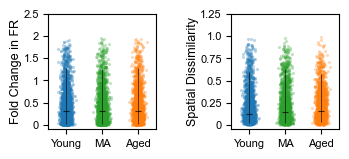

In [40]:
''' Plot Extended Data Fig. 2G, Grid Rate Remapping & Global Remapping '''

# get the data for each cell type
angle_y = 1 - yall_angles_grid
angle_ma = 1- maall_angles_grid
angle_aged = 1- agedall_angles_grid

n_y = ypct_dFR_grid.shape[0]
n_ma = mapct_dFR_grid.shape[0]
n_aged = agedpct_dFR_grid.shape[0]

# plotting params
gs = gridspec.GridSpec(1, 2, wspace=0.7)
f = plt.figure(figsize=(3.75, 1.5))
PLOT_COLORS = ['C0', 'C2', 'C1']
PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
SIG_SIZE = 5
LW_SIG = 0.8
POSITIONS = np.asarray([1, 3, 5])

# set jitter
JIT = 0.15
j_y = np.random.randn(n_y) * JIT
j_ma = np.random.randn(n_ma) * JIT
j_aged = np.random.randn(n_aged) * JIT

# CHANGE IN FIRING RATE
ax0 = plt.subplot(gs[0])
ax0.scatter(np.full(n_y, POSITIONS[0])+j_y, ypct_dFR_grid, s=PT_SIZE, lw=PT_LW, 
            color='C0', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_ma, POSITIONS[1])+j_ma, mapct_dFR_grid, s=PT_SIZE, lw=PT_LW, 
            color='C2', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_aged, POSITIONS[2])+j_aged, agedpct_dFR_grid, s=PT_SIZE, lw=PT_LW, 
            color='C1', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(ypct_dFR_grid), np.median(mapct_dFR_grid), np.median(agedpct_dFR_grid)])
dFR_5 = np.asarray([np.percentile(ypct_dFR_grid, 5), np.percentile(mapct_dFR_grid, 5), np.percentile(agedpct_dFR_grid, 5)])
dFR_95 = np.asarray([np.percentile(ypct_dFR_grid, 95), np.percentile(mapct_dFR_grid, 95), np.percentile(agedpct_dFR_grid, 95)])
ax0.plot(POSITIONS[:-1], dFR_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.plot(POSITIONS[-1], dFR_medians[-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'k'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax0.tick_params(which='major', labelsize=8)
ax0.set_xticks(POSITIONS)
ax0.set_xticklabels(['Young', 'MA', 'Aged'])
ax0.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax0.set_yticks(np.arange(0, 260, 50))
ax0.set_yticklabels([0, 0.5, 1, 1.5, 2, 2.5])
ax0.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)

# CHANGE IN SPATIAL CODING
ax1 = plt.subplot(gs[1])
ax1.scatter(np.full(n_y, POSITIONS[0])+j_y, angle_y, s=PT_SIZE, lw=PT_LW, color='C0', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_ma, POSITIONS[1])+j_ma, angle_ma, s=PT_SIZE, lw=PT_LW, color='C2', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_aged, POSITIONS[2])+j_aged, angle_aged, s=PT_SIZE, lw=PT_LW, color='C1', alpha=0.3, zorder=1)

# mark median and 95th percentiles
angle_medians = np.asarray([np.median(angle_y), np.median(angle_ma), np.median(angle_aged)])
angle_5 = np.asarray([np.percentile(angle_y, 5), np.percentile(angle_ma, 5), np.percentile(angle_aged, 5)])
angle_95 = np.asarray([np.percentile(angle_y, 95), np.percentile(angle_ma, 95), np.percentile(angle_aged, 95)])
ax1.plot(POSITIONS[:-1], angle_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.plot(POSITIONS[-1], angle_medians[-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.vlines(POSITIONS, angle_5, angle_95, lw=LW_PCT, colors=['k', 'k', 'k'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax1.tick_params(which='major', labelsize=8)
ax1.set_xticks(POSITIONS)
ax1.set_xticklabels(['Young', 'MA', 'Aged'])
ax1.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0, 1.25])
ax1.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0, 1.25])
ax1.set_ylabel('Spatial Dissimilarity', fontsize=9, labelpad=1)

f.savefig(save_folder + 'S2G.png', dpi=400, bbox_inches='tight')
f.savefig(save_folder + 'S2G.svg', dpi=400, bbox_inches='tight')

plt.show()

In [41]:
'''Assess Statistical Significance of Differences in Grid Rate & Global Remapping across Age Groups '''

# get the data for each cell type
angle_y = 1 - yall_angles_grid
angle_ma = 1- maall_angles_grid
angle_aged = 1- agedall_angles_grid

n_y = ypct_dFR_grid.shape[0]
n_ma = mapct_dFR_grid.shape[0]
n_aged = agedpct_dFR_grid.shape[0]

# firing rate (rate remapping)
print('CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(ypct_dFR_grid, mapct_dFR_grid, agedpct_dFR_grid)
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')

# agedatial coding (global remapping)
print('\nCHANGE IN SPATIAL CODING')
angle_stat, angle_p = stats.kruskal(angle_y, angle_ma, angle_aged)
print(f'global remapping (Kruskal): H = {angle_stat:.4}')
print(f'global remapping (Kruskal): p = {angle_p:.4}')

# info for each cell type
print(f'\nnyoung  grid cells total = {n_y}')
print(f'median change in firing rate = {np.median(ypct_dFR_grid):.5}')
print(f'95th percentile change in firing rate = {np.percentile(ypct_dFR_grid, 95):.5}')
print(f'median change in spatial tuning = {np.median(angle_y):.5}')
print(f'95th percentile change in spatial tuning = {np.percentile(angle_y, 95):.5}')

print(f'\nn MA grid cells total = {n_ma}')
print(f'median change in firing rate = {np.median(mapct_dFR_grid):.5}')
print(f'95th percentile change in firing rate = {np.percentile(mapct_dFR_grid, 95):.5}')
print(f'median change in spatial tuning = {np.median(angle_ma):.5}')
print(f'95th percentile change in spatial tuning = {np.percentile(angle_ma, 95):.5}')

print(f'\nn aged grid cells total = {n_aged}')
print(f'median change in firing rate = {np.median(agedpct_dFR_grid):.5}')
print(f'95th percentile change in firing rate = {np.percentile(agedpct_dFR_grid, 95):.5}')
print(f'median change in spatial tuning = {np.median(angle_aged):.5}')
print(f'95th percentile change in spatial tuning = {np.percentile(angle_aged, 95):.5}')

CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 3.213
rate remapping (Kruskal): p = 0.2006

CHANGE IN SPATIAL CODING
global remapping (Kruskal): H = 38.6
global remapping (Kruskal): p = 4.149e-09

nyoung  grid cells total = 2441
median change in firing rate = 31.455
95th percentile change in firing rate = 129.12
median change in spatial tuning = 0.12957
95th percentile change in spatial tuning = 0.59712

n MA grid cells total = 2035
median change in firing rate = 30.635
95th percentile change in firing rate = 125.86
median change in spatial tuning = 0.14451
95th percentile change in spatial tuning = 0.6278

n aged grid cells total = 2032
median change in firing rate = 32.236
95th percentile change in firing rate = 127.17
median change in spatial tuning = 0.16245
95th percentile change in spatial tuning = 0.57394


In [56]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Grid Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        for j, c in enumerate(gridcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)

            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

#gather dependent variables into lists
alldFR = list(np.concatenate((agedpct_dFR_grid, mapct_dFR_grid, ypct_dFR_grid)))
allangles = list(np.concatenate((angle_aged,angle_ma,angle_y)))

hue_order = [1.0, 3.0, 2.0]
tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, alldFR, allangles))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','dFR','angle'])

#handle NaNs
df = df.dropna(axis = 0)

#Collect Extended Data Fig 2g,h Source Data
#df.to_csv(r'C:\Users\Python\Desktop\LocalData\FigureS2\S2gh.csv', index = False, header = True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [92]:
'''Run Post Hoc Test on Grid Rate Remapping'''

import scikit_posthocs as ph

ph.posthoc_conover(df, val_col = 'dFR', group_col = 'AgeGroup', p_adjust = 'holm')

,1.0,2.0,3.0
1.0,1.000000,0.550167,0.550167
2.0,0.550167,1.000000,0.224049
3.0,0.550167,0.224049,1.000000


In [93]:
'''Run Post Hoc Test on Grid Global Remapping'''
ph.posthoc_conover(df, val_col = 'angle', group_col = 'AgeGroup', p_adjust = 'holm')

,1.0,2.0,3.0
1.0,1.000000e+00,0.135763,4.142732e-09
2.0,1.357631e-01,1.000000,2.400767e-05
3.0,4.142732e-09,0.000024,1.000000e+00


                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     dFR        
No. Observations:     6508        Method:                 REML       
No. Groups:           29          Scale:                  530.4973   
Min. group size:      60          Log-Likelihood:         -32920.6832
Max. group size:      446         Converged:              Yes        
Mean group size:      224.4                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 47.628    3.891 12.242 0.000  40.002 55.253
C(AgeGroup)[T.2.0]       -11.439    5.867 -1.950 0.051 -22.937  0.059
C(AgeGroup)[T.3.0]        -2.689    4.969 -0.541 0.588 -12.429  7.050
C(Sex)[T.M]                4.004    5.822  0.688 0.492  -7.406 15.415
C(Cohort)[T.D]            -2.295    

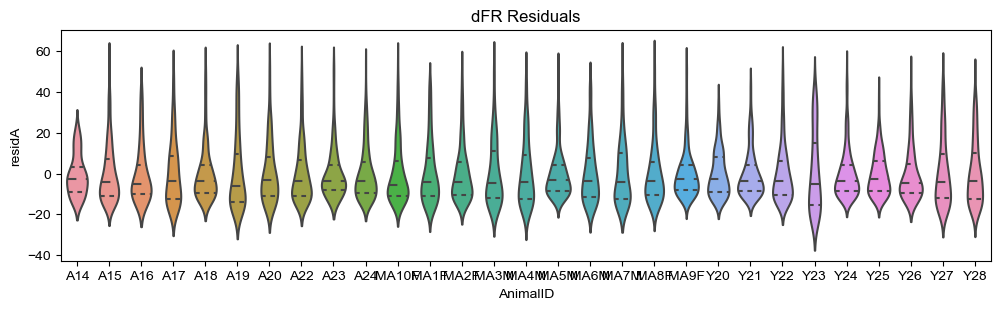

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     angle    
No. Observations:     6508        Method:                 REML     
No. Groups:           29          Scale:                  0.0112   
Min. group size:      60          Log-Likelihood:         2377.1437
Max. group size:      446         Converged:              Yes      
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.168    0.025  6.603 0.000  0.118  0.218
C(AgeGroup)[T.2.0]       -0.058    0.039 -1.502 0.133 -0.133  0.018
C(AgeGroup)[T.3.0]        0.059    0.031  1.906 0.057 -0.002  0.120
C(Sex)[T.M]              -0.013    0.040 -0.315 0.753 -0.091  0.065
C(Cohort)[T.D]            0.019    0.049  0.391 0.696 -0.077  0

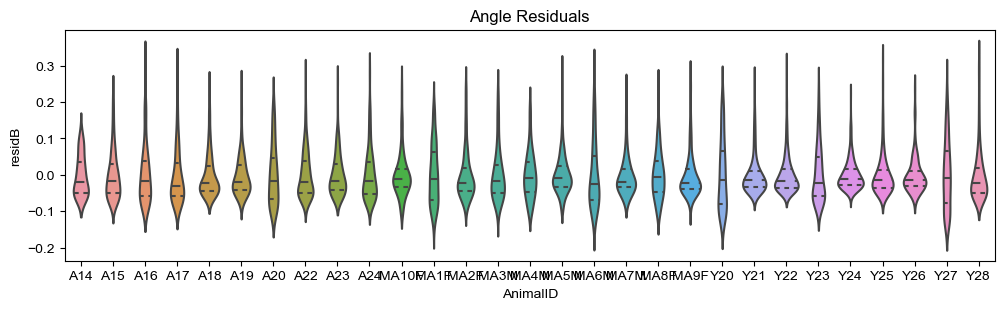

In [98]:
''' Run LMMs for Grid Cell Fold Change in FR & Spatial Dissimilarity ''' 

#Rate Remapping Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA = smf.mixedlm('dFR ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA.summary())
print(mA.wald_test_terms(scalar = False))

df['residA'] = mA.resid
residuals = mA.resid
df['mAfitted'] = mA.fittedvalues

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mA.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA', inner = 'quartile', ax = ax)
plt.title('dFR Residuals')
plt.show()

#Global Remapping Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB = smf.mixedlm('angle ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB.summary())
print(mB.wald_test_terms(scalar = False))
df['residB'] = mB.resid
residuals = mB.resid
df['mBfitted'] = mB.fittedvalues

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mB.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB', inner = 'quartile', ax = ax)
plt.title('Angle Residuals')
plt.show()


In [95]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mAfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mBfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mBfitted'])

sAfitted_seg_aged = [[] * r for i in range(r)]
sAfitted_seg_MA = [[] * r for i in range(r)]
sAfitted_seg_young = [[] * r for i in range(r)]
sBfitted_seg_aged = [[] * r for i in range(r)]
sBfitted_seg_MA = [[] * r for i in range(r)]
sBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions):
    
    try:
        animalidx = np.where(seshAanimal == m)[0][0]
        sessiona_idx = np.where(seshAanimal == m)[0]
        sessionb_idx = np.where(seshBanimal == m)[0]
    except:
        continue

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sAfitted_seg_aged[idx] = np.append(sAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            sBfitted_seg_aged[idx] = np.append(sBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sAfitted_seg_MA[idx] = np.append(sAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            sBfitted_seg_MA[idx] = np.append(sBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sAfitted_seg_young[idx] = np.append(sAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            sBfitted_seg_young[idx] = np.append(sBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1) 


n aged, MA, young mice on day 1 for fold 
10 10 8

n aged, MA, young mice on day 1 for angle
10 10 8

n aged, MA, young mice on day 2 for fold 
10 10 9

n aged, MA, young mice on day 2 for angle
10 10 9

n aged, MA, young mice on day 3 for fold 
9 10 9

n aged, MA, young mice on day 3 for angle
9 10 9

n aged, MA, young mice on day 4 for fold 
9 9 9

n aged, MA, young mice on day 4 for angle
9 9 9

n aged, MA, young mice on day 5 for fold 
8 9 9

n aged, MA, young mice on day 5 for angle
8 9 9

n aged, MA, young mice on day 6 for fold 
7 9 9

n aged, MA, young mice on day 6 for angle
7 9 9


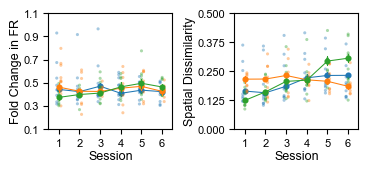

In [96]:
'''Plot Fitted Session Grid Rate & Global Remapping Data w/ LMM Results (Extended Data Fig. 2H)'''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)
f.subplots_adjust(wspace = 0.5)

g = sns.pointplot(x = df['Session'], y = mA.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([10,30,50,70,90,110])
ax[0].set_yticklabels([0.1,0.3,0.5,0.7,0.9,1.1])
ax[0].set_ylim([10,110])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.125,0.25,0.375,0.5])
ax[1].set_ylim([0.0,0.5])
ax[1].set_ylabel('Spatial Dissimilarity', fontsize=9, labelpad=1)
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(sAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for fold ')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for angle')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, sAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], sAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, sAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, sBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], sBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, sBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'S2H.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2H.svg', dpi=400, bbox_inches='tight')
plt.show()

In [58]:
''' Across the two first maps, in each session, find the fold change in FR and spatial similarity for each NGS cell  '''

ypct_dFR_ngs = []
yall_angles_ngs = []

mapct_dFR_ngs = []
maall_angles_ngs = []

agedpct_dFR_ngs = []
agedall_angles_ngs = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
    
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'       
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        posx = behaviorfil[:,0]
    
        if len(ngscells) > 0:
            
            cellidx = []
            for i, c in enumerate(ngscells):
                cdx = np.where(cell_IDs == c)[0][0]
                cellidx = np.append(cellidx, cdx)

            #get trial-averaged grid FR by context during block phase
            map0idx = d['Aidx'].astype(int)
            map1idx = d['Bidx'].astype(int)
            FR_0,_,_ = ps.tuning_curve(posx[map0idx], Y[map0idx,:], dt = 0.02, b = 2, smooth=True, l=2, SEM=False, occupancy=True)
            FR_1,_,_ = ps.tuning_curve(posx[map1idx], Y[map1idx,:], dt = 0.02, b = 2, smooth=True, l=2, SEM=False, occupancy=True)
            FR_0 = FR_0[:,cellidx.astype(int)]
            FR_1 = FR_1[:,cellidx.astype(int)]

            #get abs % diff in peak FR for each grid cell
            peak_FR_1 = np.max(FR_1, axis=0)
            peak_FR_0 = np.max(FR_0, axis=0)
            dFR = (np.abs(peak_FR_1 - peak_FR_0) / ((peak_FR_1 + peak_FR_0)/2))*100

            # get angle between maps (spatial similarity score) for each grid cell
            norms_0 = np.linalg.norm(FR_0, axis=0)
            norms_1 = np.linalg.norm(FR_1, axis=0)
            angle = np.zeros(FR_0.shape[1])
            for i, n0 in enumerate(norms_0):
                n1 = norms_1[i]
                normalized_FR_0 = FR_0[:, i]/n0
                normalized_FR_1 = FR_1[:, i]/n1   
                angle[i] = normalized_FR_0 @ normalized_FR_1

            #save results for each age group
            if m in SM_aged_mice:
                agedpct_dFR_ngs = np.append(agedpct_dFR_ngs, dFR)
                agedall_angles_ngs = np.append(agedall_angles_ngs,angle)
            elif m in SM_MA_mice:
                mapct_dFR_ngs = np.append(mapct_dFR_ngs, dFR)
                maall_angles_ngs = np.append(maall_angles_ngs,angle)
            else:
                ypct_dFR_ngs = np.append(ypct_dFR_ngs, dFR)
                yall_angles_ngs = np.append(yall_angles_ngs,angle)
                        

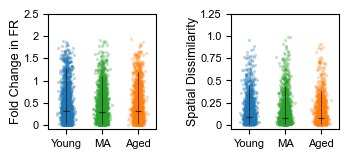

In [59]:
''' Plot NGS Rate vs. Global Remapping across Age Groups (Extended Data Fig. 2I) '''

# get the data for each cell type
angle_y = 1 - yall_angles_ngs
angle_ma = 1- maall_angles_ngs
angle_aged = 1- agedall_angles_ngs

n_y = ypct_dFR_ngs.shape[0]
n_ma = mapct_dFR_ngs.shape[0]
n_aged = agedpct_dFR_ngs.shape[0]

# plotting params
gs = gridspec.GridSpec(1, 2, wspace=0.7)
f = plt.figure(figsize=(3.75, 1.5))
PLOT_COLORS = ['C0', 'C2', 'C1']
PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
SIG_SIZE = 5
LW_SIG = 0.8
POSITIONS = np.asarray([1, 3, 5])

# set jitter
JIT = 0.15
j_y = np.random.randn(n_y) * JIT
j_ma = np.random.randn(n_ma) * JIT
j_aged = np.random.randn(n_aged) * JIT

# CHANGE IN FIRING RATE
ax0 = plt.subplot(gs[0])
ax0.scatter(np.full(n_y, POSITIONS[0])+j_y, ypct_dFR_ngs, s=PT_SIZE, lw=PT_LW, 
            color='C0', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_ma, POSITIONS[1])+j_ma, mapct_dFR_ngs, s=PT_SIZE, lw=PT_LW, 
            color='C2', alpha=0.3, zorder=1)
ax0.scatter(np.full(n_aged, POSITIONS[2])+j_aged, agedpct_dFR_ngs, s=PT_SIZE, lw=PT_LW, 
            color='C1', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(ypct_dFR_ngs), np.median(mapct_dFR_ngs), np.median(agedpct_dFR_ngs)])
dFR_5 = np.asarray([np.percentile(ypct_dFR_ngs, 5), np.percentile(mapct_dFR_ngs, 5), np.percentile(agedpct_dFR_ngs, 5)])
dFR_95 = np.asarray([np.percentile(ypct_dFR_ngs, 95), np.percentile(mapct_dFR_ngs, 95), np.percentile(agedpct_dFR_ngs, 95)])
ax0.plot(POSITIONS[:-1], dFR_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.plot(POSITIONS[-1], dFR_medians[-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'k'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax0.tick_params(which='major', labelsize=8)
ax0.set_xticks(POSITIONS)
ax0.set_xticklabels(['Young', 'MA', 'Aged'])
ax0.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax0.set_yticks(np.arange(0, 260, 50))
ax0.set_yticklabels([0, 0.5, 1, 1.5, 2, 2.5])
ax0.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)

# CHANGE IN SPATIAL CODING
ax1 = plt.subplot(gs[1])
ax1.scatter(np.full(n_y, POSITIONS[0])+j_y, angle_y, s=PT_SIZE, lw=PT_LW, color='C0', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_ma, POSITIONS[1])+j_ma, angle_ma, s=PT_SIZE, lw=PT_LW, color='C2', alpha=0.3, zorder=1)
ax1.scatter(np.full(n_aged, POSITIONS[2])+j_aged, angle_aged, s=PT_SIZE, lw=PT_LW, color='C1', alpha=0.3, zorder=1)

# mark median and 95th percentiles
angle_medians = np.asarray([np.median(angle_y), np.median(angle_ma), np.median(angle_aged)])
angle_5 = np.asarray([np.percentile(angle_y, 5), np.percentile(angle_ma, 5), np.percentile(angle_aged, 5)])
angle_95 = np.asarray([np.percentile(angle_y, 95), np.percentile(angle_ma, 95), np.percentile(angle_aged, 95)])
ax1.plot(POSITIONS[:-1], angle_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.plot(POSITIONS[-1], angle_medians[-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.vlines(POSITIONS, angle_5, angle_95, lw=LW_PCT, colors=['k', 'k', 'k'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax1.tick_params(which='major', labelsize=8)
ax1.set_xticks(POSITIONS)
ax1.set_xticklabels(['Young', 'MA', 'Aged'])
ax1.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0, 1.25])
ax1.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0, 1.25])
ax1.set_ylabel('Spatial Dissimilarity', fontsize=9, labelpad=1)

f.savefig(save_folder + 'S2I.png', dpi=400, bbox_inches='tight')
f.savefig(save_folder + 'S2I.svg', dpi=400, bbox_inches='tight')

plt.show()

In [60]:
'''Assess Statistical Significance of Age Group Differences in NGS Cell Rate & Global Remapping'''

# get the data for each cell type
angle_y = 1 - yall_angles_ngs
angle_ma = 1- maall_angles_ngs
angle_aged = 1- agedall_angles_ngs

n_y = ypct_dFR_ngs.shape[0]
n_ma = mapct_dFR_ngs.shape[0]
n_aged = agedpct_dFR_ngs.shape[0]

# firing rate (rate remapping)
print('CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(ypct_dFR_ngs, mapct_dFR_ngs, agedpct_dFR_ngs)
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')

# spatial coding (global remapping)
print('\nCHANGE IN SPATIAL CODING')
angle_stat, angle_p = stats.kruskal(angle_y, angle_ma, angle_aged)
print(f'global remapping (Kruskal): H = {angle_stat:.4}')
print(f'global remapping (Kruskal): p = {angle_p:.4}')

# info for each cell type
print(f'\nnyoung  ngs cells total = {n_y}')
print(f'median change in firing rate = {np.median(ypct_dFR_ngs):.5}')
print(f'95th percentile change in firing rate = {np.percentile(ypct_dFR_ngs, 95):.5}')
print(f'median change in spatial tuning = {np.median(angle_y):.5}')
print(f'95th percentile change in spatial tuning = {np.percentile(angle_y, 95):.5}')

print(f'\nn MA ngs cells total = {n_ma}')
print(f'median change in firing rate = {np.median(mapct_dFR_ngs):.5}')
print(f'95th percentile change in firing rate = {np.percentile(mapct_dFR_ngs, 95):.5}')
print(f'median change in spatial tuning = {np.median(angle_ma):.5}')
print(f'95th percentile change in spatial tuning = {np.percentile(angle_ma, 95):.5}')

print(f'\nn aged ngs cells total = {n_aged}')
print(f'median change in firing rate = {np.median(agedpct_dFR_ngs):.5}')
print(f'95th percentile change in firing rate = {np.percentile(agedpct_dFR_ngs, 95):.5}')
print(f'median change in spatial tuning = {np.median(angle_aged):.5}')
print(f'95th percentile change in spatial tuning = {np.percentile(angle_aged, 95):.5}')

CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 6.272
rate remapping (Kruskal): p = 0.04346

CHANGE IN SPATIAL CODING
global remapping (Kruskal): H = 14.21
global remapping (Kruskal): p = 0.0008203

nyoung  ngs cells total = 2154
median change in firing rate = 31.989
95th percentile change in firing rate = 127.62
median change in spatial tuning = 0.085458
95th percentile change in spatial tuning = 0.44254

n MA ngs cells total = 2347
median change in firing rate = 29.759
95th percentile change in firing rate = 110.97
median change in spatial tuning = 0.07337
95th percentile change in spatial tuning = 0.43449

n aged ngs cells total = 2058
median change in firing rate = 31.123
95th percentile change in firing rate = 119.33
median change in spatial tuning = 0.081696
95th percentile change in spatial tuning = 0.37782


In [61]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each NGS Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        ngscell = d['ngscell'].astype(bool)
        ngsdcells = cell_IDs[ngscell]
        
        for j, c in enumerate(ngscells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)

            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

#gather dependent variables into lists
alldFR = list(np.concatenate((agedpct_dFR_ngs, mapct_dFR_ngs, ypct_dFR_ngs)))
allangles = list(np.concatenate((angle_aged,angle_ma,angle_y)))

hue_order = [1.0, 3.0, 2.0]
tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, alldFR, allangles))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','dFR','angle'])

#handle NaNs
df = df.dropna(axis = 0)

#Collect Extended Data Fig 2i,j Source Data
df.to_csv(r'C:\Users\Python\Desktop\LocalData\FigureS2\S2ij.csv', index = False, header = True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [80]:
'''Run Post Hoc Test on NGS Rate Remapping'''
ph.posthoc_conover(df, val_col = 'dFR', group_col = 'AgeGroup', p_adjust = 'holm')

,1.0,2.0,3.0
1.0,1.000000,0.880187,0.678558
2.0,0.880187,1.000000,0.880187
3.0,0.678558,0.880187,1.000000


In [81]:
'''Run Post Hoc Test on NGS Global Remapping'''
ph.posthoc_conover(df, val_col = 'angle', group_col = 'AgeGroup', p_adjust = 'holm')

,1.0,2.0,3.0
1.0,1.000000,0.255106,0.313069
2.0,0.255106,1.000000,0.702811
3.0,0.313069,0.702811,1.000000


                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     dFR        
No. Observations:     6559        Method:                 REML       
No. Groups:           24          Scale:                  458.3501   
Min. group size:      144         Log-Likelihood:         -32862.1420
Max. group size:      288         Converged:              Yes        
Mean group size:      273.3                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 37.131    3.791  9.794 0.000  29.700 44.561
C(AgeGroup)[T.2.0]        11.184    4.903  2.281 0.023   1.574 20.793
C(AgeGroup)[T.3.0]         4.493    4.892  0.919 0.358  -5.095 14.082
C(Sex)[T.M]               -5.005    3.914 -1.279 0.201 -12.676  2.666
C(Cohort)[T.D]             8.449    

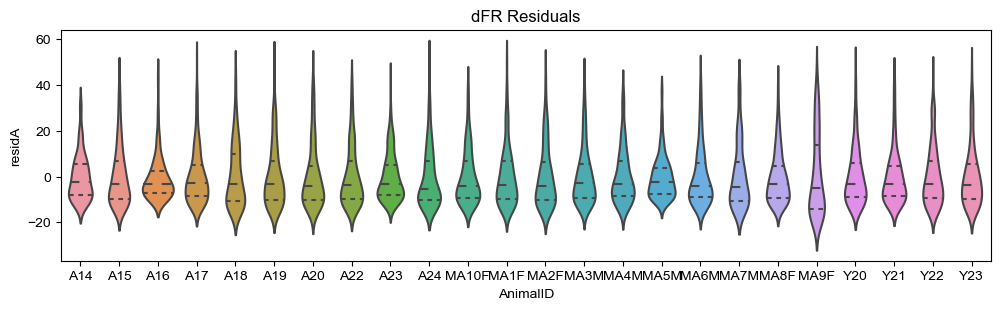

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     angle    
No. Observations:     6559        Method:                 REML     
No. Groups:           24          Scale:                  0.0065   
Min. group size:      144         Log-Likelihood:         3661.7134
Max. group size:      288         Converged:              Yes      
Mean group size:      273.3                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.096    0.013  7.244 0.000  0.070  0.122
C(AgeGroup)[T.2.0]        0.036    0.017  2.090 0.037  0.002  0.069
C(AgeGroup)[T.3.0]        0.017    0.017  1.024 0.306 -0.016  0.051
C(Sex)[T.M]              -0.004    0.013 -0.339 0.735 -0.030  0.021
C(Cohort)[T.D]            0.007    0.019  0.370 0.711 -0.030  0

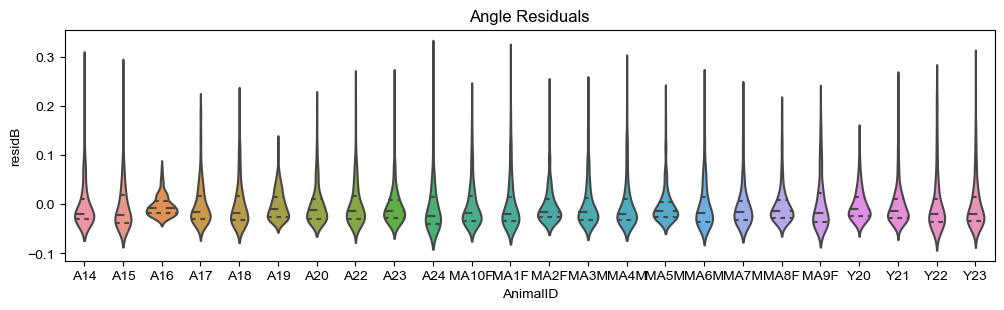

In [82]:
''' LMMs for Fold Change in FR & Spatial Dissimilarity ''' 

#Rate Remapping Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA = smf.mixedlm('dFR ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA.summary())
print(mA.wald_test_terms(scalar = False))

df['residA'] = mA.resid
df['mAfitted'] = mA.fittedvalues
residuals = mA.resid

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mA.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA', inner = 'quartile', ax = ax)
plt.title('dFR Residuals')
plt.show()

#Global Remapping Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB = smf.mixedlm('angle ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB.summary())
print(mB.wald_test_terms(scalar = False))

df['residB'] = mB.resid
df['mBfitted'] = mB.fittedvalues
residuals = mB.resid

'''
## Optional Additional Residual Plots
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mB.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB', inner = 'quartile', ax = ax)
plt.title('Angle Residuals')
plt.show()


In [83]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mAfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mBfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mBfitted'])

sAfitted_seg_aged = [[] * r for i in range(r)]
sAfitted_seg_MA = [[] * r for i in range(r)]
sAfitted_seg_young = [[] * r for i in range(r)]
sBfitted_seg_aged = [[] * r for i in range(r)]
sBfitted_seg_MA = [[] * r for i in range(r)]
sBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions):
    
    try:
        animalidx = np.where(seshAanimal == m)[0][0]
        sessiona_idx = np.where(seshAanimal == m)[0]
        sessionb_idx = np.where(seshBanimal == m)[0]
    except:
        continue

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sAfitted_seg_aged[idx] = np.append(sAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            sBfitted_seg_aged[idx] = np.append(sBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sAfitted_seg_MA[idx] = np.append(sAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            sBfitted_seg_MA[idx] = np.append(sBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sAfitted_seg_young[idx] = np.append(sAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            sBfitted_seg_young[idx] = np.append(sBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for fold 
10 10 4

n aged, MA, young mice on day 1 for angle
10 10 4

n aged, MA, young mice on day 2 for fold 
10 10 4

n aged, MA, young mice on day 2 for angle
10 10 4

n aged, MA, young mice on day 3 for fold 
10 10 4

n aged, MA, young mice on day 3 for angle
10 10 4

n aged, MA, young mice on day 4 for fold 
9 10 4

n aged, MA, young mice on day 4 for angle
9 10 4

n aged, MA, young mice on day 5 for fold 
8 9 4

n aged, MA, young mice on day 5 for angle
8 9 4

n aged, MA, young mice on day 6 for fold 
8 9 4

n aged, MA, young mice on day 6 for angle
8 9 4


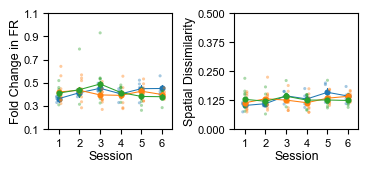

In [84]:
'''Plot Fitted Session NGS Cell Rate & Global Remapping Data w/ LMM Results (Extended Data Fig. 2J)'''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)
f.subplots_adjust(wspace = 0.5)

g = sns.pointplot(x = df['Session'], y = mA.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([10,30,50,70,90,110])
ax[0].set_yticklabels([0.1,0.3,0.5,0.7,0.9,1.1])
ax[0].set_ylim([10,110])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.125,0.25,0.375,0.5])
ax[1].set_ylim([0.0,0.5])
ax[1].set_ylabel('Spatial Dissimilarity', fontsize=9, labelpad=1)
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(sAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for fold ')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for angle')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, sAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], sAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, sAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, sBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], sBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, sBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'S2J.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S2J.svg', dpi=400, bbox_inches='tight')
plt.show()

In [86]:
''' Compare Grid vs. NGS Remapping in each Age Group'''

print('FOLD CHANGE GRID VS. NGS, BY AGE GROUP:')

print('\nYoung Grid Rate Remapping Strength Mean, SEM:')
print(np.mean(ypct_dFR_grid), stats.sem(ypct_dFR_grid))

print('Young NGS Rate Remapping Strength Mean, SEM:')
print(np.mean(ypct_dFR_ngs), stats.sem(ypct_dFR_ngs))

print('\nMA Grid Rate Remapping Strength Mean, SEM:')
print(np.mean(mapct_dFR_ngs),stats.sem(mapct_dFR_ngs))

print('MA NGS Rate Remapping Strength Mean, SEM:')
print(np.mean(mapct_dFR_grid), stats.sem(mapct_dFR_grid))

print('\nAged Grid Rate Remapping Strength Mean, SEM:')
print(np.mean(agedpct_dFR_grid), stats.sem(agedpct_dFR_grid))

print('Aged NGS Rate Remapping Strength Mean, SEM:')
print(np.mean(agedpct_dFR_ngs), stats.sem(agedpct_dFR_ngs))

young_dFR_stat, young_dFR_p = stats.ranksums(ypct_dFR_grid, ypct_dFR_ngs)
print(f'\nyoung grid vs. NGS (rank sums): p = {young_dFR_p:.4}')
ma_dFR_stat, ma_dFR_p = stats.ranksums(mapct_dFR_grid, mapct_dFR_ngs)
print(f'MA grid vs. NGS (rank sums): p = {ma_dFR_p:.4}')
aged_dFR_stat, aged_dFR_p = stats.ranksums(agedpct_dFR_grid, agedpct_dFR_ngs)
print(f'aged grid vs. NGS (rank sums): p = {aged_dFR_p:.4}')

print('\nSPATIAL DISSIMILARITY GRID VS. NGS, BY AGE GROUP:')

print('\nYoung Grid Global Remapping Strength Mean, SEM:')
print(np.mean((1 - yall_angles_grid)), stats.sem((1 - yall_angles_grid)))

print('Young NGS Global Remapping Strength Mean, SEM:')
print(np.mean((1 - yall_angles_ngs)), stats.sem((1 - yall_angles_ngs)))

print('\nMA Grid Global Remapping Strength Mean, SEM:')
print(np.mean((1 - maall_angles_grid)), stats.sem((1 - maall_angles_grid)))

print('MA NGS Global Remapping Strength Mean, SEM:')
print(np.mean((1 - maall_angles_ngs)), stats.sem((1 - maall_angles_ngs)))

print('\nAged Grid Global Remapping Strength Mean, SEM:')
print(np.mean((1 - agedall_angles_grid)), stats.sem((1 - agedall_angles_grid)))

print('Aged NGS Global Remapping Strength Mean, SEM:')
print(np.mean((1 - agedall_angles_ngs)), stats.sem((1 - agedall_angles_ngs)))

young_angle_stat, young_angle_p = stats.ranksums((1 - yall_angles_grid), (1 - yall_angles_ngs))
print(f'\nyoung grid vs. NGS (rank sums): p = {young_angle_p:.4}')
ma_angle_stat, ma_angle_p = stats.ranksums((1 - maall_angles_grid), (1 - maall_angles_ngs))
print(f'MA grid vs. NGS (rank sums): p = {ma_angle_p:.4}')
aged_angle_stat, aged_angle_p = stats.ranksums((1 - agedall_angles_grid), (1 - agedall_angles_ngs))
print(f'aged grid vs. NGS (rank sums): p = {aged_angle_p:.4}')

FOLD CHANGE GRID VS. NGS, BY AGE GROUP:

Young Grid Rate Remapping Strength Mean, SEM:
43.29315155757542 0.7878498708209921
Young NGS Rate Remapping Strength Mean, SEM:
43.70780044682034 0.8374519450377412

MA Grid Rate Remapping Strength Mean, SEM:
39.66405037706018 0.7120346527806776
MA NGS Rate Remapping Strength Mean, SEM:
42.2275448636093 0.8557376629470413

Aged Grid Rate Remapping Strength Mean, SEM:
43.93363381841084 0.8631580901379653
Aged NGS Rate Remapping Strength Mean, SEM:
41.738377571398836 0.8050867304880245

young grid vs. NGS (rank sums): p = 0.7261
MA grid vs. NGS (rank sums): p = 0.3273
aged grid vs. NGS (rank sums): p = 0.141

SPATIAL DISSIMILARITY GRID VS. NGS, BY AGE GROUP:

Young Grid Global Remapping Strength Mean, SEM:
0.19479769092318838 0.0036517634952376444
Young NGS Global Remapping Strength Mean, SEM:
0.1320133275041874 0.003012168991936314

MA Grid Global Remapping Strength Mean, SEM:
0.20606364636182717 0.004181780718383339
MA NGS Global Remapping Stren